In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

датасет с соревнований от Циана. Даннные тут имеют большое количество пропусков => надо восстановить что получится и отбросить то, что не имеет смысла восстанавливать/слишком много пропусков.

Также имеет смысл создать несколько своих признаков, чтобы "заменить" очень похожие друг на друга признаки/добавть больше информации

Ремарка! Блок статистики выполнялся уже после построения "наивной" регрессии, поэтому там уже есть некоторые шаги по борьбе с гетероскедастичностью

Делаем заготовку для палитры

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

custom_palette = ["#009c38", "#8a0128"]
blue_gradient = ['#07031a','#110838', '#170b4d', '#221170', '#3d24b3', '#664ddb', '#9782fa']
cmap = mcolors.LinearSegmentedColormap.from_list('blue_lin_grad', ['#080212', '#1d7bf5'])
males = '#331a8f'
females = '#ea46f0'
background_color = "#f7d2ec"
fill_color = "#491bbf"
font_style = 'serif'

plt.rcParams['axes.facecolor'] = background_color
plt.rcParams['figure.facecolor'] = background_color
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['font.family'] = font_style

### Грузим данные

In [ ]:
df = pd.read_csv("main_data.csv")

In [ ]:
df.head()

region                                address       price  total_area  \
0    msk  Москва, Большой Толмачёвский переулок  1996610000       459.4   
1    msk              Москва, Самотечная ул., 5    66970000       160.0   
2    msk                        Москва, Ильинка   378820000       157.4   
3    msk             Москва, М. Бронная ул., 32   110500000       110.5   
4    msk                        Москва, Ильинка  1031300000       271.8   

   kitchen_area  living_area  rooms_count  floor  floors_number  build_date  \
0          81.4        173.3          5.0      7              8         NaN   
1          25.0        119.0          3.0      3              9      1892.0   
2          41.1         50.7          3.0      3              5         NaN   
3          15.0         61.0          3.0      2              6      1912.0   
4          57.1        123.8          5.0      5              5         NaN   

   ...  longitude   latitude passenger_elevator cargo_elevator  \
0  ...  37.620949  55.739757                1.0            1.0   
1  ...  37.618318  55.775165                1.0            1.0   
2  ...  37.623649  55.755140                NaN            NaN   
3  ...  37.593524  55.764197                1.0            0.0   
4  ...  37.623509  55.755201                NaN            NaN   

                                     metro  metro_distance  \
0      Полянка,Новокузнецкая,Третьяковская          6,10,4   
1  Цветной бульвар,Достоевская,Сухаревская          6,9,13   
2            Площадь Революции,Театральная             3,6   
3           Маяковская,Пушкинская,Тверская        10,10,10   
4            Площадь Революции,Театральная             3,6   

       metro_transport         district  is_apartments  is_auction  
0  walk,walk,transport     Якиманка,ЦАО            0.0           0  
1       walk,walk,walk     Тверской,ЦАО            NaN           1  
2            walk,walk     Тверской,ЦАО            0.0           0  
3       walk,walk,walk  Пресненский,ЦАО            NaN           1  
4            walk,walk     Тверской,ЦАО            0.0           0  

[5 rows x 26 columns]

In [ ]:
df.shape

(5978, 26)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   region              5978 non-null   object 
 1   address             5978 non-null   object 
 2   price               5978 non-null   int64  
 3   total_area          5978 non-null   float64
 4   kitchen_area        3702 non-null   float64
 5   living_area         3834 non-null   float64
 6   rooms_count         5248 non-null   float64
 7   floor               5978 non-null   int64  
 8   floors_number       5978 non-null   int64  
 9   build_date          1497 non-null   float64
 10  isСomplete          3797 non-null   float64
 11  complitation_year   3869 non-null   float64
 12  house_material      5371 non-null   object 
 13  parking             1432 non-null   object 
 14  decoration          1222 non-null   object 
 15  balcony             1405 non-null   float64
 16  longit

## Обрабатываем пропуски

In [ ]:
import seaborn as sns


#### Пропуски района тут не очень много пропусков  их легко восстановить по координатам

In [ ]:
df_missed_district = df[df['district'].isna()]
df_missed_district['region'].unique()

array(['nsk'], dtype=object)

Тут все пропуски района из Новосиба

In [ ]:
df_missed_district = df[df['district'].isna()]
df_missed_district


df_known_district = df.dropna(subset=['district'])

df_missed_district = df_missed_district[df_missed_district['region'] =='nsk']
df_known_district = df_known_district[df_known_district['region'] =='nsk']


In [ ]:
df_nsk = df[df['region'] == 'nsk']

nsk_districts = {}

for district in df_nsk['district'].dropna().unique():
    district_data = df_nsk[df_nsk['district'] == district]
    avg_lat = district_data['latitude'].mean()
    avg_lon = district_data['longitude'].mean()
    nsk_districts[district] = (avg_lat, avg_lon)


In [ ]:
!pip install geopy

In [ ]:
from geopy.distance import geodesic

def find_closest_district(missed_lat, missed_lon, district_coords):
    closest_district = None
    min_distance = float('inf')
    for district, (lat, lon) in district_coords.items():
        distance = geodesic((missed_lat, missed_lon), (lat, lon)).meters
        if distance < min_distance:
            min_distance = distance
            closest_district = district

    return closest_district

df_missed_district_original = df_missed_district.copy()


for idx, row in df[df['district'].isna()].iterrows():
    missed_lat = row['latitude']
    missed_lon = row['longitude']
    closest_district = find_closest_district(missed_lat, missed_lon, nsk_districts)
    if closest_district:
        df.at[idx, 'district'] = closest_district

for idx, row in df_missed_district_original.iterrows():
    if row['district'] != df.at[idx, 'district']:
        print(f"Адрес: {row['address']} - Было: {row['district']} - Стало: {df.at[idx, 'district']}")

Адрес: Новосибирск, Кировский район, Затулинский жилмассив, улица Зорге, 229/3 - Было: nan - Стало: Затулинский,Кировский
Адрес: Новосибирск, Кировский район, Затулинский жилмассив, улица Зорге, 229/2 - Было: nan - Стало: Затулинский,Кировский
Адрес: Новосибирск, Кировский район, Затулинский жилмассив, улица Зорге, 229/3 - Было: nan - Стало: Затулинский,Кировский
Адрес: Новосибирск, Затулинский жилмассив, улица Зорге, 229/1 - Было: nan - Стало: Затулинский,Кировский
Адрес: Новосибирск, Кедровая улица, 80/2 - Было: nan - Стало: Стрижи,Заельцовский
Адрес: Новосибирск, Кировский район, Затулинский жилмассив, улица Зорге, 229/3 - Было: nan - Стало: Затулинский,Кировский
Адрес: Новосибирск, Кедровая улица, 80/1 - Было: nan - Стало: Родники,Калининский
Адрес: Новосибирск, Затулинский жилмассив, улица Зорге, 229/1 - Было: nan - Стало: Затулинский,Кировский
Адрес: Новосибирск, Кировский район, Затулинский жилмассив, улица Зорге, 229/3 - Было: nan - Стало: Затулинский,Кировский
Адрес: Новосибир

#### обработаем пропуски в материалах домов

сначала смотрим какие материалы есть вообще

In [ ]:
df['house_material'].unique()

array(['monolith', 'brick', 'monolithBrick', nan, 'panel', 'stalin',
       'block', 'old', 'wood', 'gasSilicateBlock'], dtype=object)

рассмотрим распределение количества материалов

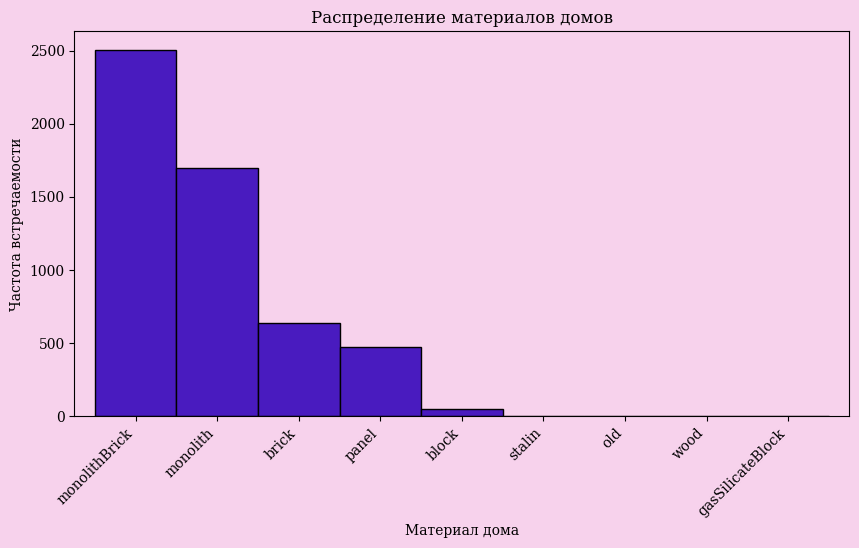

In [ ]:
import matplotlib.pyplot as plt


material_counts = df['house_material'].value_counts()

plt.figure(figsize=(10, 5))
material_counts.plot(kind='bar', color=fill_color, edgecolor='black', width = 1)

plt.xlabel("Материал дома")
plt.ylabel("Частота встречаемости")
plt.title("Распределение материалов домов")
plt.xticks(rotation=45, ha='right')

plt.show()



заменим материалы модой по району. если не получится так, то по городу

In [ ]:
import pandas as pd

districts_with_missing = df[df['house_material'].isna()]['district'].unique()

for district in districts_with_missing:
    mode_value_district = df.loc[df['district'] == district, 'house_material'].mode()
    if not mode_value_district.empty:
        df.loc[(df['district'] == district) &
               (df['house_material'].isna()), 'house_material'] = mode_value_district[0]
    else:
        mode_value_region = df['house_material'].mode()
        if not mode_value_region.empty:
            df.loc[(df['district'] == district) &
             (df['house_material'].isna()), 'house_material'] = mode_value_region[0]


In [ ]:
print(df['house_material'].isna().sum())

0


#### Заполним пропуски количества комнат. будем заполнять на основе того что уже есть (да, есть свободные планировки и тп, но это не мешает нам заменить таким обарзом)

In [ ]:
df[df['rooms_count'].isna()]

region                                        address       price  \
17      msk           Москва, Ленинградский проспект, 37/6   125000000   
30      msk                                Москва, Ильинка    90450000   
39      msk           Москва, 1-я Тверская-Ямская улица, 2  2455020000   
103     msk                        Москва, улица Палиха, 4   215900000   
204     msk                     Москва, Мосфильмовская, 88    50000000   
...     ...                                            ...         ...   
5951    nng              Нижний Новгород, Барминская улица    21102000   
5953    nng  Нижний Новгород, 2-я Оранжерейная улица, 4Ак1    21256950   
5954    nng  Нижний Новгород, 2-я Оранжерейная улица, 4Ак2    21431850   
5973    nng              Нижний Новгород, Барминская улица    23857470   
5977    nng    Нижний Новгород, 2-я Оранжерейная улица, 4А    24140800   

      total_area  kitchen_area  living_area  rooms_count  floor  \
17        135.30           NaN          NaN          NaN     37   
30         40.20           5.0          NaN          NaN      1   
39       1067.40           NaN          NaN          NaN      9   
103       239.90           NaN        191.0          NaN     10   
204        84.30          14.0         65.0          NaN     14   
...          ...           ...          ...          ...    ...   
5951       70.34           NaN          NaN          NaN     12   
5953      128.83           NaN          NaN          NaN     19   
5954      129.89           NaN          NaN          NaN     19   
5973      126.23           NaN          NaN          NaN      2   
5977      150.88           NaN          NaN          NaN     19   

      floors_number  build_date  ...  longitude   latitude passenger_elevator  \
17               37      2021.0  ...  37.542213  55.794173                NaN   
30                5         NaN  ...  37.623509  55.755201                NaN   
39                9         NaN  ...  37.594868  55.771088                NaN   
103              10      2019.0  ...  37.598582  55.783752                1.0   
204              21         NaN  ...  37.490299  55.704844                3.0   
...             ...         ...  ...        ...        ...                ...   
5951             14         NaN  ...  43.976423  56.314535                NaN   
5953             19         NaN  ...  44.001232  56.304092                NaN   
5954             19         NaN  ...  44.000546  56.304228                NaN   
5973             12         NaN  ...  43.976423  56.314535                NaN   
5977             19         NaN  ...  43.999945  56.303876                NaN   

     cargo_elevator                                     metro  metro_distance  \
17              NaN                      Аэропорт,ЦСКА,Динамо        12,13,15   
30              NaN             Площадь Революции,Театральная             3,6   
39              NaN            Маяковская,Тверская,Пушкинская         1,10,11   
103             NaN  Менделеевская,Новослободская,Белорусская          3,6,13   
204             NaN            Раменки,Ломоносовский проспект            12,4   
...             ...                                       ...             ...   
5951            NaN         Горьковская,Московская,Чкаловская          17,4,6   
5953            NaN          Горьковская,Московская,Ленинская         16,9,10   
5954            NaN          Горьковская,Московская,Ленинская         16,9,10   
5973            NaN         Горьковская,Московская,Чкаловская          17,4,6   
5977            NaN          Горьковская,Московская,Ленинская          6,9,10   

                    metro_transport                     district  \
17                   walk,walk,walk              Хорошевский,САО   
30                        walk,walk                 Тверской,ЦАО   
39                   walk,walk,walk                 Тверской,ЦАО   
103                  walk,walk,walk                 Тверской,ЦАО   
204                  walk

<ipython-input-18-a2b4e26fe5f6>:4: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(x='rooms_count', y='total_area',


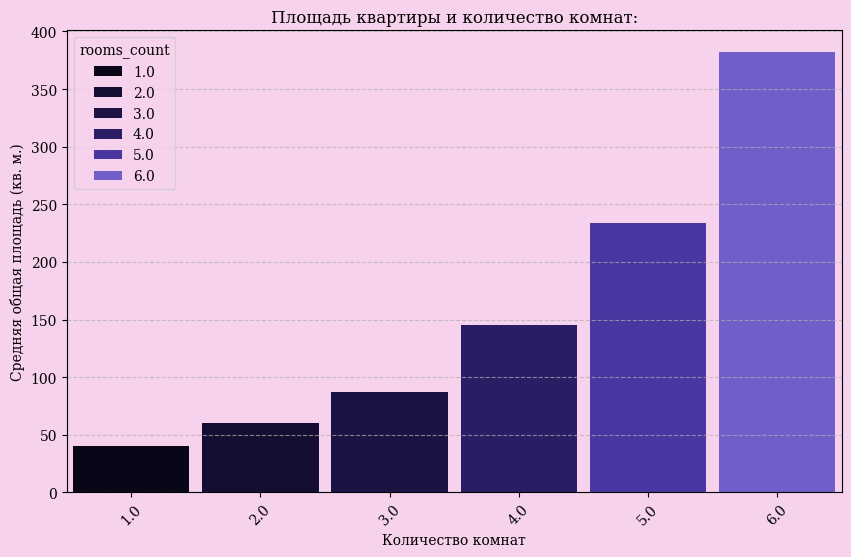

In [ ]:
avg_area_by_rooms = df.groupby('rooms_count')['total_area'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='rooms_count', y='total_area',
            hue='rooms_count',
            data=avg_area_by_rooms, palette=blue_gradient,
            width = 0.9)

plt.xlabel("Количество комнат")
plt.ylabel("Средняя общая площадь (кв. м.)")
plt.title("Площадь квартиры и количество комнат:")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
cities = df['region'].unique()
cities

array(['msk', 'spb', 'ekb', 'nsk', 'kzn', 'nng'], dtype=object)

<ipython-input-20-30d524d7b49d>:14: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x='rooms_count', y='total_area',hue='rooms_count', data=avg_area_by_rooms, ax=ax, palette= custom_palette)
<ipython-input-20-30d524d7b49d>:14: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x='rooms_count', y='total_area',hue='rooms_count', data=avg_area_by_rooms, ax=ax, palette= custom_palette)


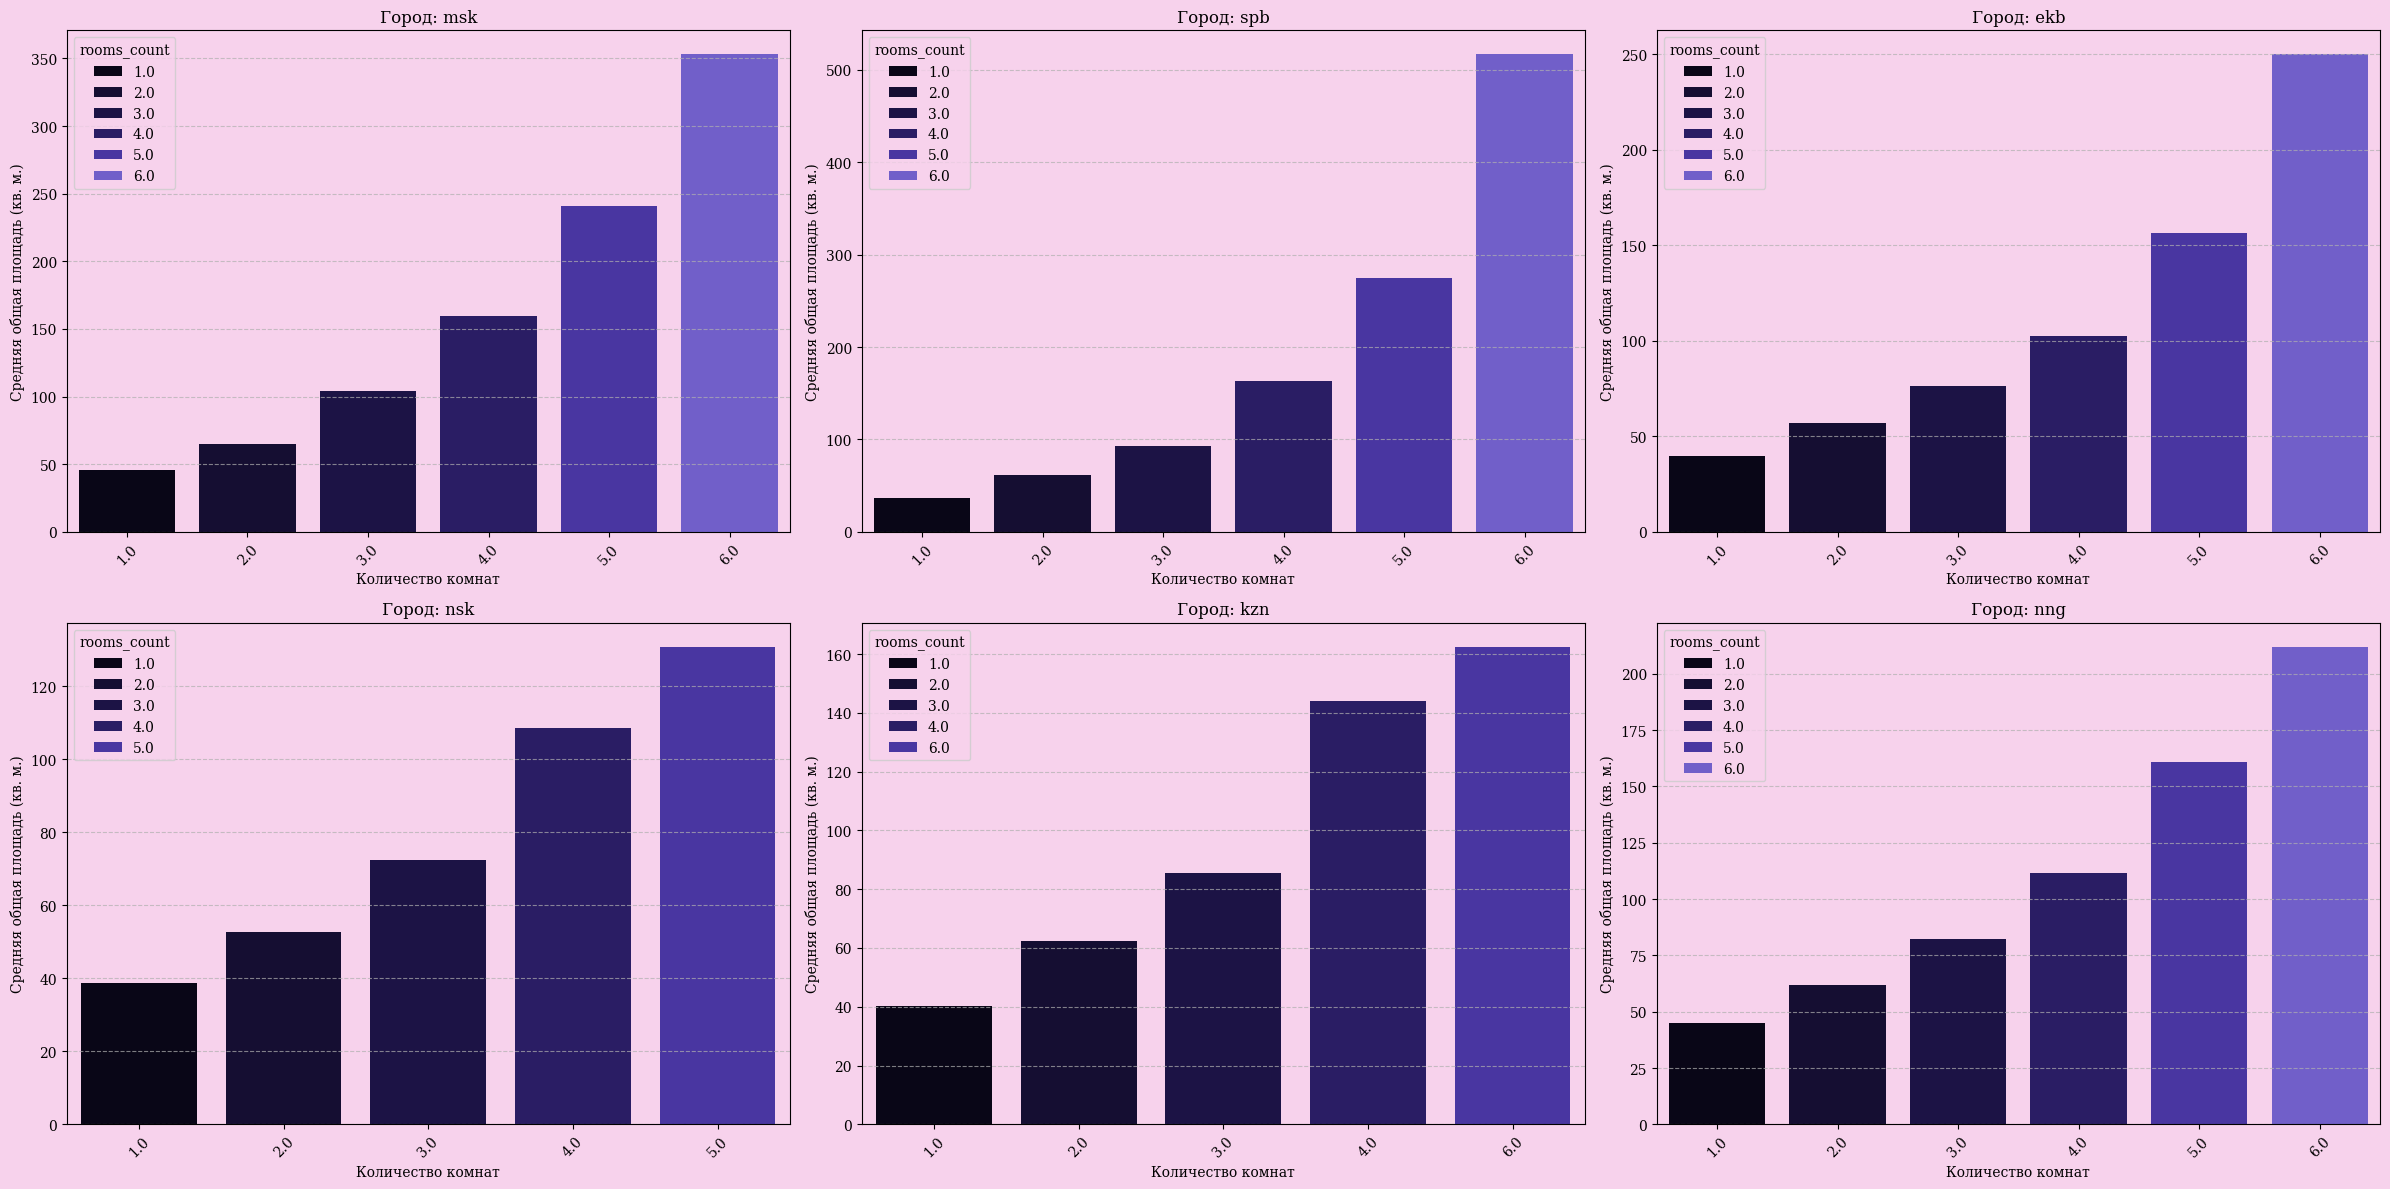

In [ ]:
import seaborn as sns

cities = df['region'].unique()

fig, axes = plt.subplots(2, 3, figsize=(24, 12))
custom_palette = blue_gradient[:6]

for i, city in enumerate(cities):
    ax = axes[i // 3, i % 3]

    city_data = df[df['region'] == city]
    avg_area_by_rooms = city_data.groupby('rooms_count')['total_area'].mean().reset_index()

    sns.barplot(x='rooms_count', y='total_area',hue='rooms_count', data=avg_area_by_rooms, ax=ax, palette= custom_palette)

    ax.set_xlabel("Количество комнат")
    ax.set_ylabel("Средняя общая площадь (кв. м.)")
    ax.set_title(f"Город: {city}")
    ax.xaxis.set_tick_params(rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()


исходили из следующей логики: заменяем NaNы на среднее количество комнат в квартирах такой же площади

In [ ]:
for city in cities:
    city_data = df[df['region'] == city]
    avg_area_by_rooms = city_data.groupby('rooms_count')['total_area'].mean().reset_index()
    missing_rooms = city_data[city_data['rooms_count'].isna()]

    for index, row in missing_rooms.iterrows():
        closest_room_count = avg_area_by_rooms.iloc[(avg_area_by_rooms['total_area'] - row['total_area']).abs().argmin()]['rooms_count']
        df.loc[index, 'rooms_count'] = closest_room_count

missing_after = df['rooms_count'].isna().sum()
print(f"Осталось пропусков в rooms_count: {missing_after}")

Осталось пропусков в rooms_count: 0


#### Пропуски кухонь аналогичным образом как и комнаты

In [ ]:
df_missed_kithcen = df[df['kitchen_area'].isna()]
df_missed_kithcen

region                                            address      price  \
5       msk  Россия, Москва, Московский международный делов...  480765635   
10      msk                   Москва, Софийская набережная, 36  109213650   
11      msk     Россия, Москва, 2-й Неопалимовский переулок, 3  158220000   
12      msk                  Москва, Софийская набережная, 10Д  750000000   
15      msk     Россия, Москва, 2-й Неопалимовский переулок, 3  195840000   
...     ...                                                ...        ...   
5970    nng                  Нижний Новгород, улица Белинского   23604000   
5971    nng      Нижний Новгород, улица Владимира Высоцкого, 1   23588614   
5972    nng                  Нижний Новгород, Грузинская улица   23780000   
5973    nng                  Нижний Новгород, Барминская улица   23857470   
5977    nng        Нижний Новгород, 2-я Оранжерейная улица, 4А   24140800   

      total_area  kitchen_area  living_area  rooms_count  floor  \
5         294.60           NaN          NaN          4.0     80   
10        127.00           NaN          NaN          3.0      3   
11         87.90           NaN          NaN          2.0      4   
12        251.80           NaN          NaN          4.0      4   
15        108.80           NaN          NaN          3.0      4   
...          ...           ...          ...          ...    ...   
5970      112.40           NaN          NaN          4.0      2   
5971       95.70           NaN          NaN          3.0     13   
5972       67.93           NaN         60.0          2.0      2   
5973      126.23           NaN          NaN          4.0      2   
5977      150.88           NaN          NaN          5.0     19   

      floors_number  build_date  ...  longitude   latitude passenger_elevator  \
5                85         NaN  ...  37.534325  55.749765                4.0   
10                7         NaN  ...  37.623959  55.747611                4.0   
11                9      2023.0  ...  37.582493  55.739250                0.0   
12                4         NaN  ...  37.616379  55.746403                NaN   
15                9      2023.0  ...  37.582493  55.739250                0.0   
...             ...         ...  ...        ...        ...                ...   
5970              9         NaN  ...  44.003461  56.310719                NaN   
5971             21         NaN  ...  44.073758  56.310416                NaN   
5972              6         NaN  ...  44.002546  56.321229                NaN   
5973             12         NaN  ...  43.976423  56.314535                NaN   
5977             19         NaN  ...  43.999945  56.303876                NaN   

     cargo_elevator                                              metro  \
5               1.0          Деловой центр,Международная,Деловой центр   
10              4.0            Новокузнецкая,Третьяковская,Китай-город   
11              0.0                  Парк Культуры,Смоленская,Киевская   
12              NaN  Боровицкая,Александровский сад,Библиотека им. ...   
15              0.0                  Парк Культуры,Смоленская,Киевская   
...             ...                                                ...   
5970            NaN                     Горьковская,Московская,Стрелка   
5971            2.0                     Горьковская,Стрелка,Московская   
5972            NaN                     Горьковская,Московская,Стрелка   
5973            NaN                  Горьковская,Московская,Чкаловская   
5977            NaN                   Горьковская,Московская,Ленинская   

      metro_distance                metro_transport  \
5              3,3,4                 walk,walk,walk   
10          11,11,15                 walk,walk,walk   
11          10,14,16                 walk,walk,walk   
12          13,14,15                 walk,walk,walk   
15          10,14,16                 walk,walk,walk   
...              ...                            ...   
5970          9,7,10       w

<ipython-input-23-caaad7fac871>:3: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(x='rooms_count', y='kitchen_area',


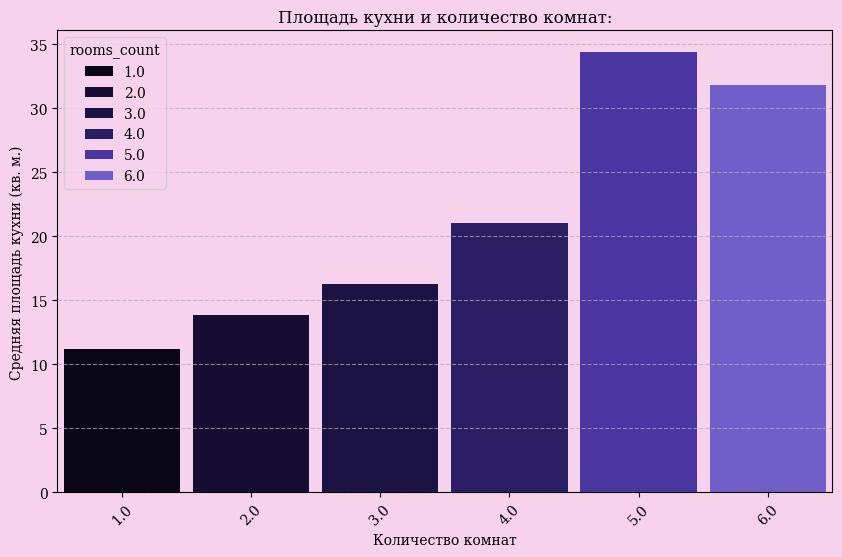

In [ ]:
avg_kitchen_area_by_rooms = df.groupby('rooms_count')['kitchen_area'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='rooms_count', y='kitchen_area',
            hue='rooms_count',
            data=avg_kitchen_area_by_rooms, palette=blue_gradient,
            width=0.9)
plt.xlabel("Количество комнат")
plt.ylabel("Средняя площадь кухни (кв. м.)")
plt.title("Площадь кухни и количество комнат:")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
avg_kitchen_area_by_rooms = df.groupby('rooms_count')['kitchen_area'].transform('mean')

df['kitchen_area'] = df['kitchen_area'].fillna(avg_kitchen_area_by_rooms)

#### В целом нам не особо важно какое метро рядом (тк есть district - район ), нас больше интересует расстояние до метро ну и примерно как до него добраться

In [ ]:
df['metro_distance'] = df['metro_distance'].apply(
    lambda x: sum(map(int, x.split(','))) / len(x.split(',')) if pd.notna(x) else x
)

In [ ]:
df.head()

region                                address       price  total_area  \
0    msk  Москва, Большой Толмачёвский переулок  1996610000       459.4   
1    msk              Москва, Самотечная ул., 5    66970000       160.0   
2    msk                        Москва, Ильинка   378820000       157.4   
3    msk             Москва, М. Бронная ул., 32   110500000       110.5   
4    msk                        Москва, Ильинка  1031300000       271.8   

   kitchen_area  living_area  rooms_count  floor  floors_number  build_date  \
0          81.4        173.3          5.0      7              8         NaN   
1          25.0        119.0          3.0      3              9      1892.0   
2          41.1         50.7          3.0      3              5         NaN   
3          15.0         61.0          3.0      2              6      1912.0   
4          57.1        123.8          5.0      5              5         NaN   

   ...  longitude   latitude passenger_elevator cargo_elevator  \
0  ...  37.620949  55.739757                1.0            1.0   
1  ...  37.618318  55.775165                1.0            1.0   
2  ...  37.623649  55.755140                NaN            NaN   
3  ...  37.593524  55.764197                1.0            0.0   
4  ...  37.623509  55.755201                NaN            NaN   

                                     metro  metro_distance  \
0      Полянка,Новокузнецкая,Третьяковская        6.666667   
1  Цветной бульвар,Достоевская,Сухаревская        9.333333   
2            Площадь Революции,Театральная        4.500000   
3           Маяковская,Пушкинская,Тверская       10.000000   
4            Площадь Революции,Театральная        4.500000   

       metro_transport         district  is_apartments  is_auction  
0  walk,walk,transport     Якиманка,ЦАО            0.0           0  
1       walk,walk,walk     Тверской,ЦАО            NaN           1  
2            walk,walk     Тверской,ЦАО            0.0           0  
3       walk,walk,walk  Пресненский,ЦАО            NaN           1  
4            walk,walk     Тверской,ЦАО            0.0           0  

[5 rows x 26 columns]

In [ ]:
# df['metro_transport'] = df['metro_transport'].apply(
#     lambda x: 'walk' if pd.notna(x) and 'walk' in x.split(',') else 'transport' if pd.notna(x) else x
# )

df['metro_transport'] = df['metro_transport'].apply(
    lambda x: 1 if pd.notna(x) and 'walk' in x.split(',') else 0 if pd.notna(x) else x
)

In [ ]:
df.head()

region                                address       price  total_area  \
0    msk  Москва, Большой Толмачёвский переулок  1996610000       459.4   
1    msk              Москва, Самотечная ул., 5    66970000       160.0   
2    msk                        Москва, Ильинка   378820000       157.4   
3    msk             Москва, М. Бронная ул., 32   110500000       110.5   
4    msk                        Москва, Ильинка  1031300000       271.8   

   kitchen_area  living_area  rooms_count  floor  floors_number  build_date  \
0          81.4        173.3          5.0      7              8         NaN   
1          25.0        119.0          3.0      3              9      1892.0   
2          41.1         50.7          3.0      3              5         NaN   
3          15.0         61.0          3.0      2              6      1912.0   
4          57.1        123.8          5.0      5              5         NaN   

   ...  longitude   latitude passenger_elevator cargo_elevator  \
0  ...  37.620949  55.739757                1.0            1.0   
1  ...  37.618318  55.775165                1.0            1.0   
2  ...  37.623649  55.755140                NaN            NaN   
3  ...  37.593524  55.764197                1.0            0.0   
4  ...  37.623509  55.755201                NaN            NaN   

                                     metro  metro_distance  metro_transport  \
0      Полянка,Новокузнецкая,Третьяковская        6.666667              1.0   
1  Цветной бульвар,Достоевская,Сухаревская        9.333333              1.0   
2            Площадь Революции,Театральная        4.500000              1.0   
3           Маяковская,Пушкинская,Тверская       10.000000              1.0   
4            Площадь Революции,Театральная        4.500000              1.0   

          district  is_apartments  is_auction  
0     Якиманка,ЦАО            0.0           0  
1     Тверской,ЦАО            NaN           1  
2     Тверской,ЦАО            0.0           0  
3  Пресненский,ЦАО            NaN           1  
4     Тверской,ЦАО            0.0           0  

[5 rows x 26 columns]

In [ ]:
for city in df['region'].unique():
    city_data = df[df['region'] == city]

    districts_with_missing = city_data[city_data['metro_transport'].isna()]['district'].unique()

    city_mode = city_data['metro_transport'].dropna().mode()
    city_mode_value = city_mode[0] if not city_mode.empty else None

    for district in districts_with_missing:
        district_mode = city_data[city_data['district'] == district]['metro_transport'].dropna().mode()

        if not district_mode.empty:
            mode_value = district_mode[0]
        else:
            mode_value = city_mode_value

        df.loc[(df['region'] == city) & (df['district'] == district) & (df['metro_transport'].isna()), 'metro_transport'] = mode_value



In [ ]:
for city in df['region'].unique():
    city_data = df[df['region'] == city]

    districts_with_missing = city_data[city_data['metro_distance'].isna()]['district'].unique()

    city_mean = city_data['metro_distance'].dropna().mean()

    for district in districts_with_missing:
        district_mean = city_data[city_data['district'] == district]['metro_distance'].dropna().mean()

        if pd.notna(district_mean):
            mean_value = district_mean
        else:
            mean_value = city_mean

        df.loc[(df['region'] == city) & (df['district'] == district) & (df['metro_distance'].isna()), 'metro_distance'] = mean_value


#### Анализируем ситуацию с лифтами

In [ ]:
df[df['passenger_elevator'] == 0]

region                                            address      price  \
11      msk     Россия, Москва, 2-й Неопалимовский переулок, 3  158220000   
15      msk     Россия, Москва, 2-й Неопалимовский переулок, 3  195840000   
35      msk            Россия, Москва, Рыбников переулок, 13/3   45000000   
431     msk                 Москва, 1-й Сетуньский проезд, вл6   23990000   
451     msk                 Москва, 1-й Сетуньский проезд, вл6   25990000   
...     ...                                                ...        ...   
5070    nng  Нижегородская область, Нижний Новгород городск...    7800000   
5207    nng        Россия, Нижний Новгород, Проезжая улица, 13    3300000   
5225    nng     Россия, Нижний Новгород, улица Белинского, 60А   27400000   
5388    nng       Россия, Нижний Новгород, Должанская улица, 5    5200000   
5584    nng       Россия, Нижний Новгород, Суетинская улица, 9    9470000   

      total_area  kitchen_area  living_area  rooms_count  floor  \
11          87.9     13.838852          NaN          2.0      4   
15         108.8     16.261416          NaN          3.0      4   
35          87.0     16.261416          NaN          3.0      1   
431         49.0     13.838852          NaN          2.0      3   
451         54.2     13.838852          NaN          2.0      3   
...          ...           ...          ...          ...    ...   
5070        61.0      6.000000         44.0          3.0      4   
5207        25.5      4.500000         15.8          1.0      2   
5225        88.0     12.300000         50.8          3.0      5   
5388        30.2      6.000000         18.0          1.0      1   
5584        45.1     13.838852         31.0          2.0      5   

      floors_number  build_date  ...  longitude   latitude passenger_elevator  \
11                9      2023.0  ...  37.582493  55.739250                0.0   
15                9      2023.0  ...  37.582493  55.739250                0.0   
35                4      1880.0  ...  37.634892  55.767149                0.0   
431              41         NaN  ...  37.540209  55.732220                0.0   
451              41         NaN  ...  37.540209  55.732220                0.0   
...             ...         ...  ...        ...        ...                ...   
5070              6      1973.0  ...  44.025336  56.321865                0.0   
5207              2      1959.0  ...  43.836852  56.224182                0.0   
5225              9      2009.0  ...  44.001144  56.311541                0.0   
5388              5      1965.0  ...  43.958753  56.329717                0.0   
5584              5      1964.0  ...  43.987382  56.324955                0.0   

     cargo_elevator                                         metro  \
11              0.0             Парк Культуры,Смоленская,Киевская   
15              0.0             Парк Культуры,Смоленская,Киевская   
35              0.0  Тургеневская,Сретенский бульвар,Чистые пруды   
431             0.0       Воробьёвы горы,Парк Культуры,Спортивная   
451             0.0       Воробьёвы горы,Парк Культуры,Спортивная   
...             ...                                           ...   
5070            0.0                                           NaN   
5207            0.0         Парк культуры,Кировская,Автозаводская   
5225            1.0              Горьковская,Московская,Ленинская   
5388            0.0                                           NaN   
5584            0.0             Горьковская,Московская,Чкаловская   

      metro_distance  metro_transport                    district  \
11         13.333333              1.0               Хамовники,ЦАО   
15         13.333333              1.0               Хамовники,ЦАО   
35          5.333333              1.0          Красносельский,ЦАО   
431         4.666667              0.0                 Раменки,ЗАО   
451         4.666667              0.0                 Раменки,ЗАО   
...              ...              ...                      

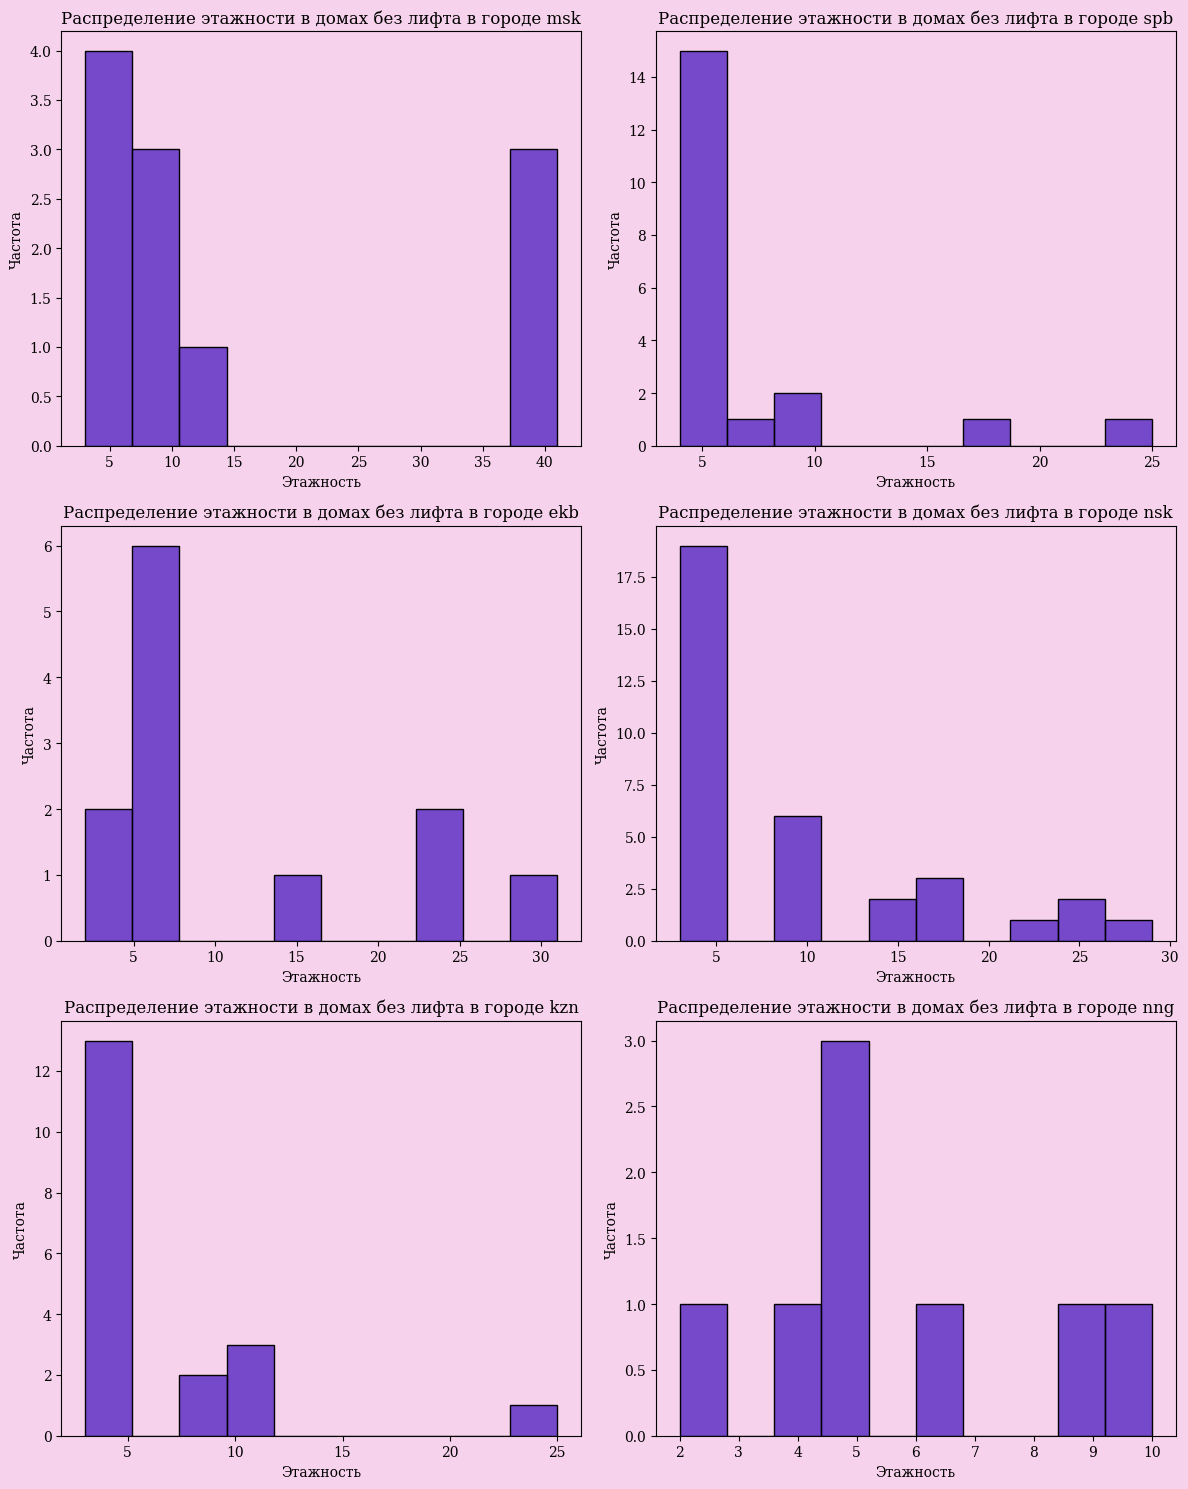

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_no_elevator = df[df['passenger_elevator'] == 0]
cities = df_no_elevator['region'].unique()
plt.figure(figsize=(12, 15))
for i, city in enumerate(cities):
    plt.subplot(3, 2, i+1)
    city_data = df_no_elevator[df_no_elevator['region'] == city]
    sns.histplot(city_data['floors_number'],bins=10, color=fill_color)
    plt.title(f'Распределение этажности в домах без лифта в городе {city}')
    plt.xlabel('Этажность')
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()



In [ ]:
df.loc[(df['passenger_elevator'].isna()) & (df['floors_number'] <= 6), 'passenger_elevator'] = 0

In [ ]:
df.loc[(df['floors_number'] >= 7) & (df['passenger_elevator'].isna()), 'passenger_elevator'] = 1

In [ ]:
df.loc[(df['floors_number'] >=7 ) & (df['passenger_elevator'] == 0), 'passenger_elevator'] = 1

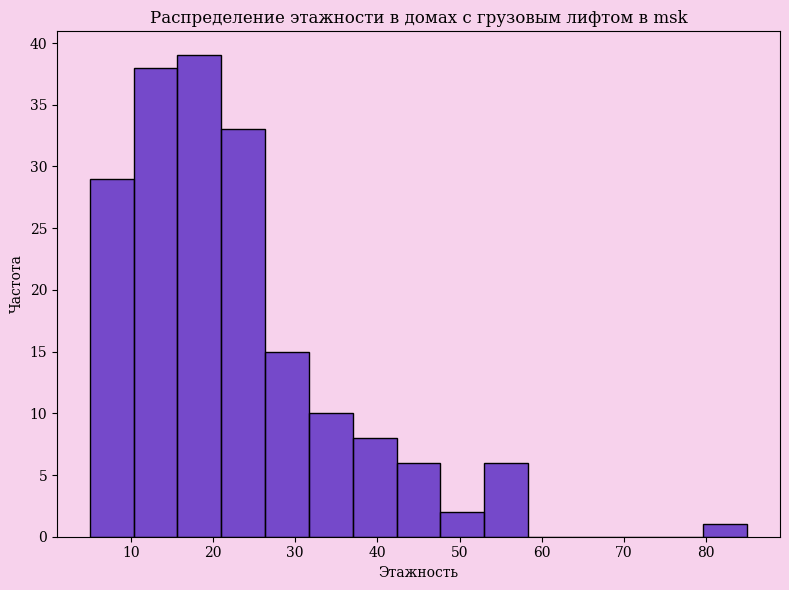

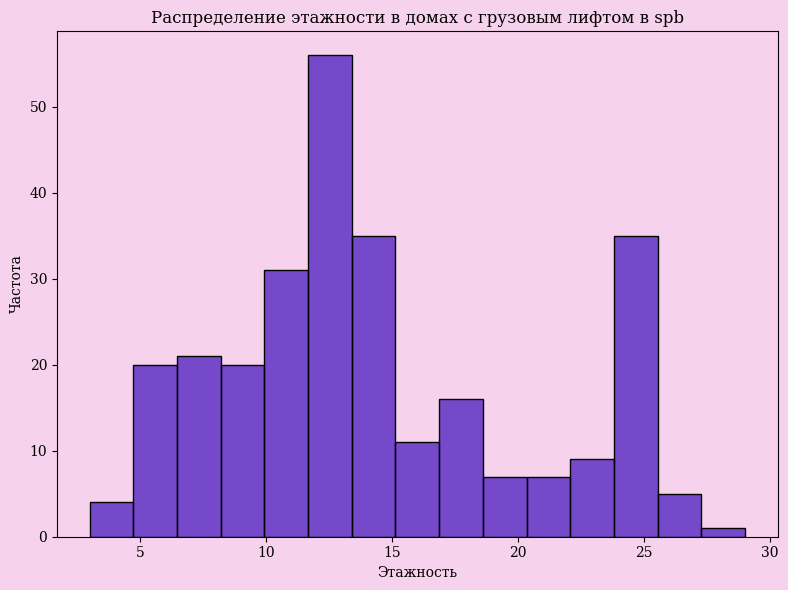

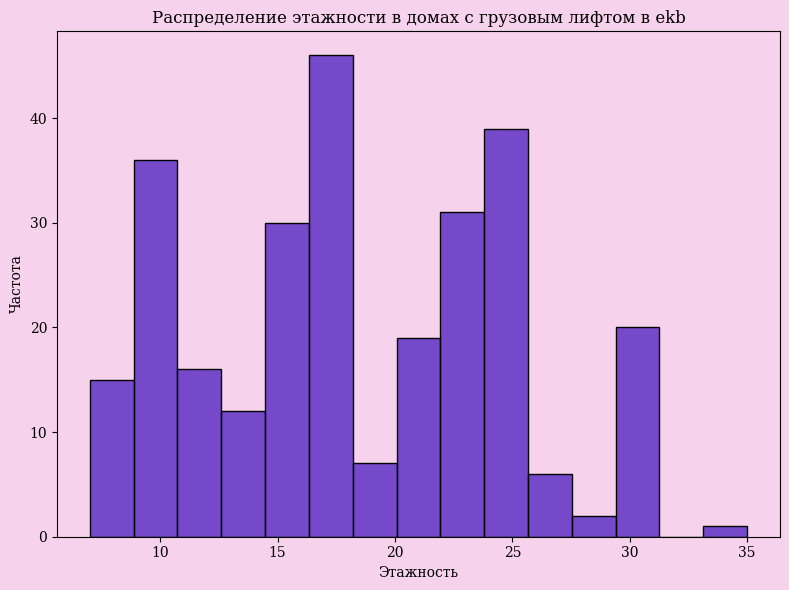

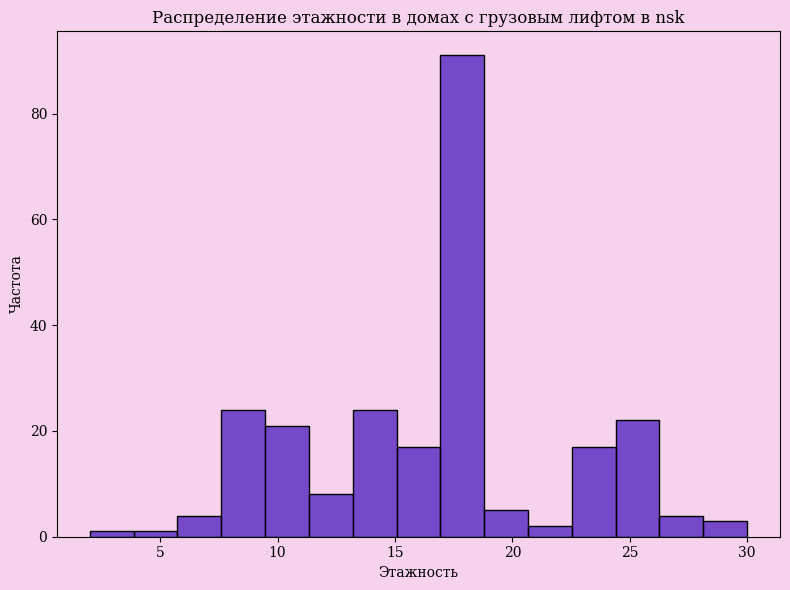

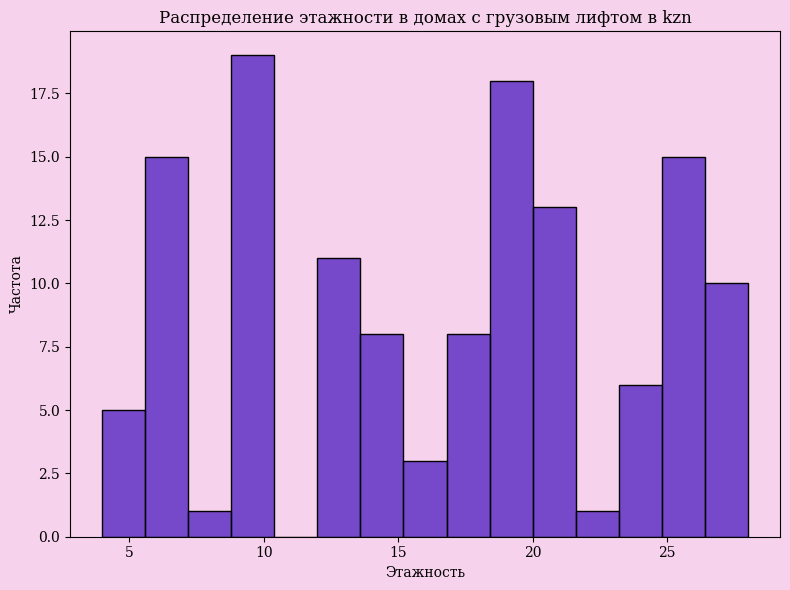

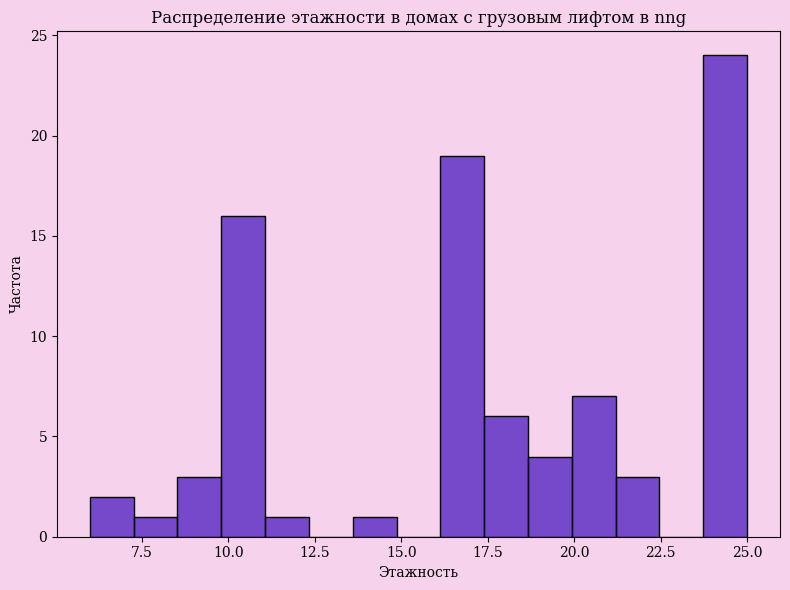

In [ ]:
df_no_elevator = df[df['cargo_elevator'] == 1]
cities = df_no_elevator['region'].unique()
for city in cities:
    city_data = df_no_elevator[df_no_elevator['region'] == city]
    plt.figure(figsize=(8, 6))
    sns.histplot(city_data['floors_number'], bins=15, color = fill_color)
    plt.title(f'Распределение этажности в домах с грузовым лифтом в {city}')
    plt.xlabel('Этажность')
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

In [ ]:
df.loc[(df['cargo_elevator'].isna()) & (df['floors_number'] <= 10), 'cargo_elevator'] = 0

In [ ]:
df.loc[(df['cargo_elevator'].isna()) & (df['floors_number'] > 10), 'cargo_elevator'] = 1

In [ ]:
columns_to_drop = ['parking',
                   'decoration', 'balcony']
df = df.drop(columns=columns_to_drop, errors='ignore')

In [ ]:
df.isna().sum()

region                   0
address                  0
price                    0
total_area               0
kitchen_area             0
living_area           2144
rooms_count              0
floor                    0
floors_number            0
build_date            4481
isСomplete            2181
complitation_year     2109
house_material           0
longitude                0
latitude                 0
passenger_elevator       0
cargo_elevator           0
metro                  874
metro_distance           0
metro_transport          0
district                 0
is_apartments          938
is_auction               0
dtype: int64

#### Восстановим апартаменты...

In [ ]:
df.isna().sum()

region                   0
address                  0
price                    0
total_area               0
kitchen_area             0
living_area           2144
rooms_count              0
floor                    0
floors_number            0
build_date            4481
isСomplete            2181
complitation_year     2109
house_material           0
longitude                0
latitude                 0
passenger_elevator       0
cargo_elevator           0
metro                  874
metro_distance           0
metro_transport          0
district                 0
is_apartments          938
is_auction               0
dtype: int64

In [ ]:
df.loc[(df['total_area'] < 28) & pd.isna(df['is_apartments']), 'is_apartments'] = 1
df.loc[(df['total_area'] >= 400) & pd.isna(df['is_apartments']), 'is_apartments'] = 1
df['is_apartments'].fillna(0, inplace=True)

<ipython-input-42-0964609fd85d>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['is_apartments'].fillna(0, inplace=True)


In [ ]:
df.isna().sum()

region                   0
address                  0
price                    0
total_area               0
kitchen_area             0
living_area           2144
rooms_count              0
floor                    0
floors_number            0
build_date            4481
isСomplete            2181
complitation_year     2109
house_material           0
longitude                0
latitude                 0
passenger_elevator       0
cargo_elevator           0
metro                  874
metro_distance           0
metro_transport          0
district                 0
is_apartments            0
is_auction               0
dtype: int64

In [ ]:
len(df)

5978

In [ ]:
df_stat = df.copy()

#### Сделаем признак city_center_distance

для удобства рассчитаем расстояния до центра города

In [ ]:
regions = df['region'].unique()
regions

array(['msk', 'spb', 'ekb', 'nsk', 'kzn', 'nng'], dtype=object)

In [ ]:
center_coords = {
    # lat lon
    'msk': (55.7558, 37.6173),
    'spb': (59.9343, 30.3351),
    'ekb': (56.8389, 60.6057),
    'nsk': (55.0084, 82.9357),
    'kzn': (55.8304, 49.0661),
    'nng': (56.2965, 43.9361)
}

In [ ]:
def calculate_center_distance(lat, lon, city):
    if city in center_coords:
        city_lat, city_lon = center_coords[city]
        return geodesic((lat, lon), (city_lat, city_lon)).meters
    else:
        return None

df['center_distance'] = df.apply(lambda row: calculate_center_distance(row['latitude'], row['longitude'], row['region']), axis=1)

print(df[['region', 'latitude', 'longitude', 'center_distance']].head())

  region   latitude  longitude  center_distance
0    msk  55.739757  37.620949      1800.842863
1    msk  55.775165  37.618318      2156.998537
2    msk  55.755140  37.623649       405.316785
3    msk  55.764197  37.593524      1761.245252
4    msk  55.755201  37.623509       395.516034


In [ ]:
df['center_distance'] = np.log(df['center_distance'])

In [ ]:
df_stat = df.copy()

## Наивная модель

In [ ]:
from utils import *

Ниже рассмотрим первый вариант "наивная модель". Мы не проводили никакую обработку за исключением заполнения пропусков, ну и может быть минимальной нормализации.

удалим признаки которые нам скорее помешают, чем помогут.

In [ ]:
df.drop(columns = ['living_area', 'build_date', 'isСomplete', 'complitation_year',
                   'metro'
], inplace=True, errors='ignore')

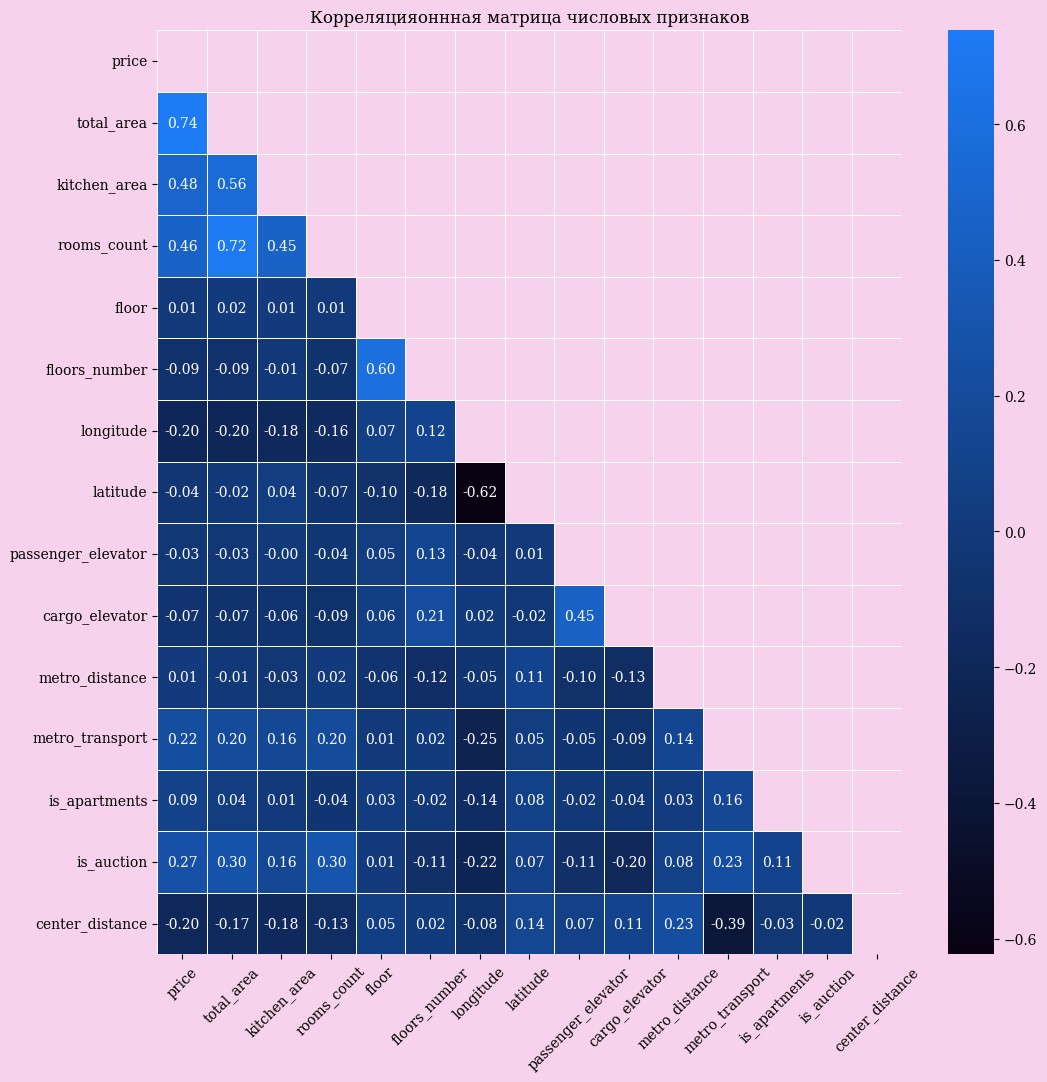

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_features = df.select_dtypes(include=np.number)

plt.figure(figsize=(12, 12))
sns.heatmap(numeric_features.corr(), annot=True, cmap=cmap,
            fmt=".2f",linewidths=0.5,
            mask=np.triu(numeric_features.corr()))
plt.title('Корреляцияоннная матрица числовых признаков')
x_ticks = plt.xticks(rotation=45)
plt.show()


In [ ]:
features_= ['total_area', 'floor','floors_number', 'longitude','passenger_elevator',
            'cargo_elevator','metro_distance', 'metro_transport', 'is_apartments', 'is_auction']

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     745.7
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:28:33   Log-Likelihood:            -1.1543e+05
No. Observations:                5978   AIC:                         2.309e+05
Df Residuals:                    5967   BIC:                         2.310e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -3.919e+07   3.86

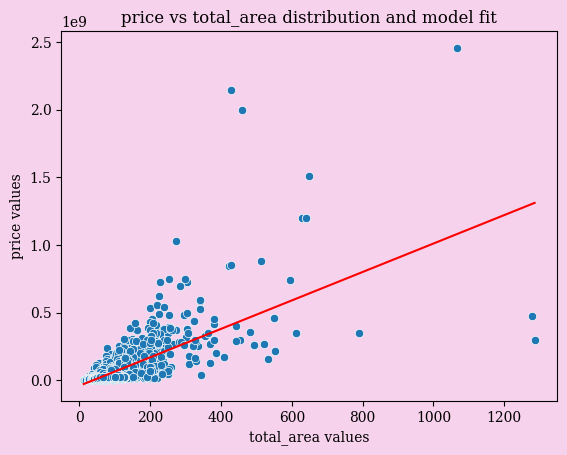

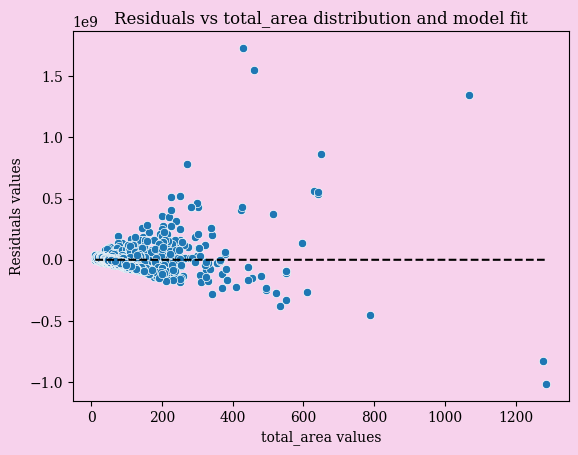

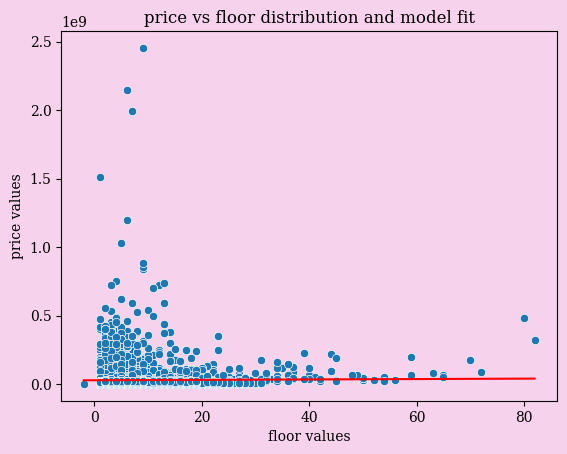

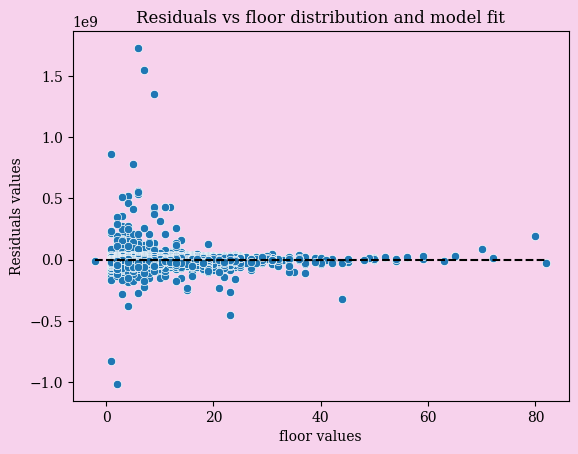

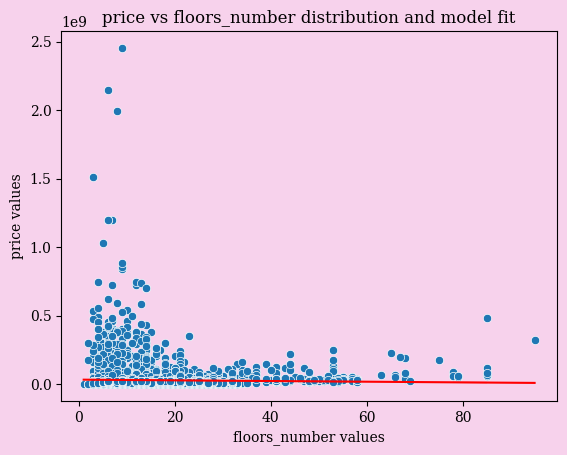

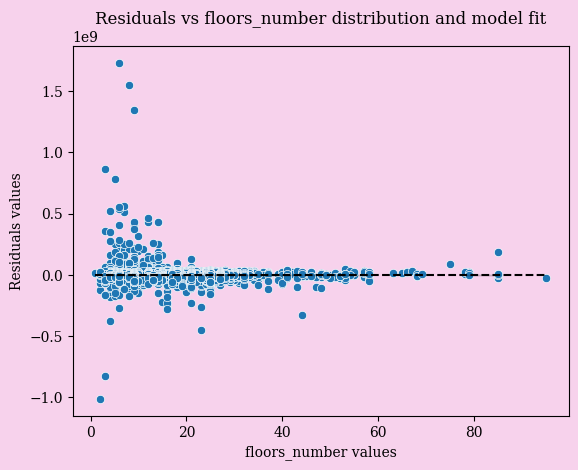

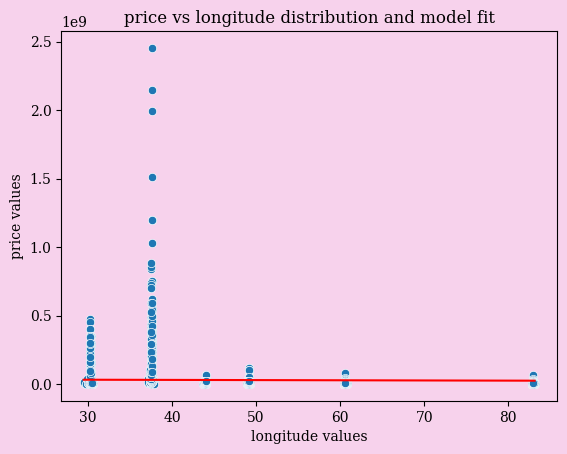

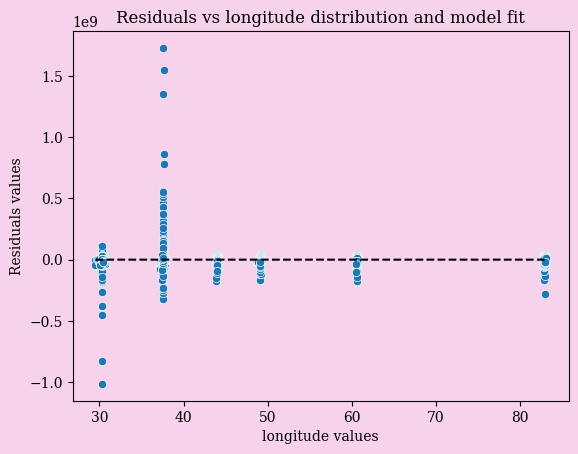

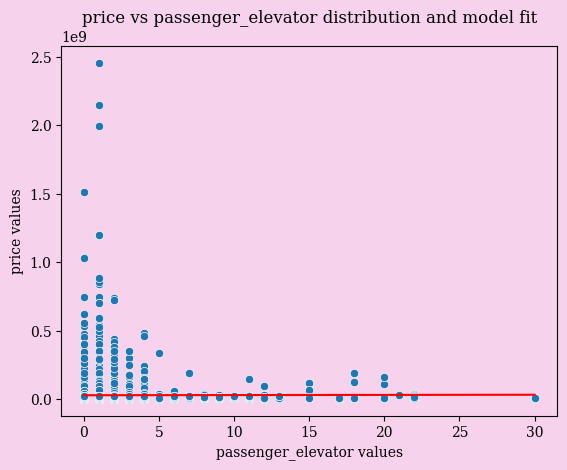

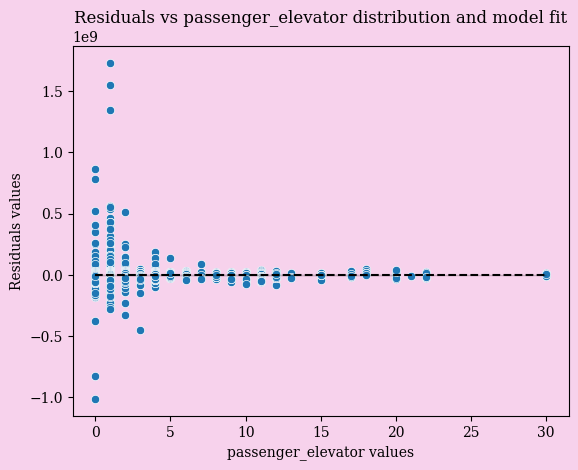

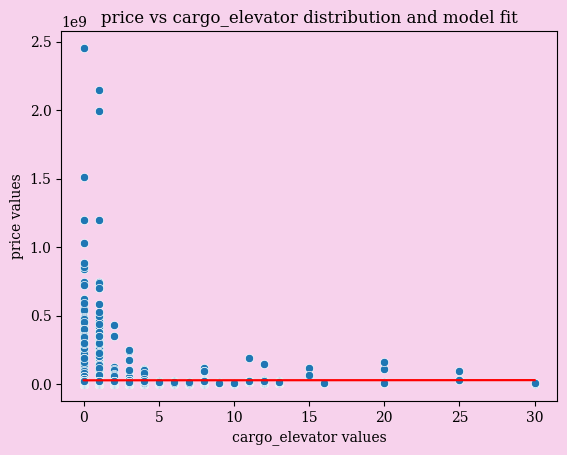

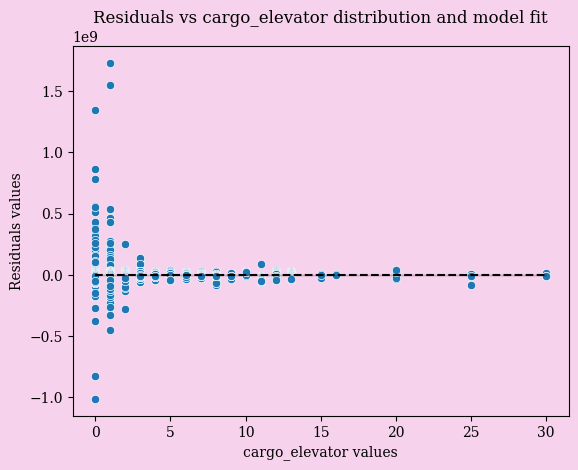

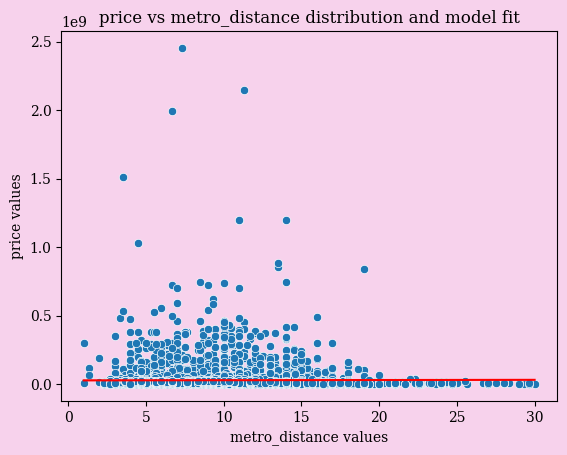

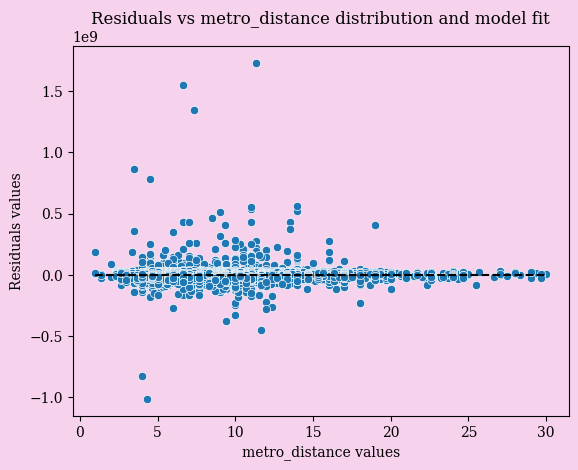

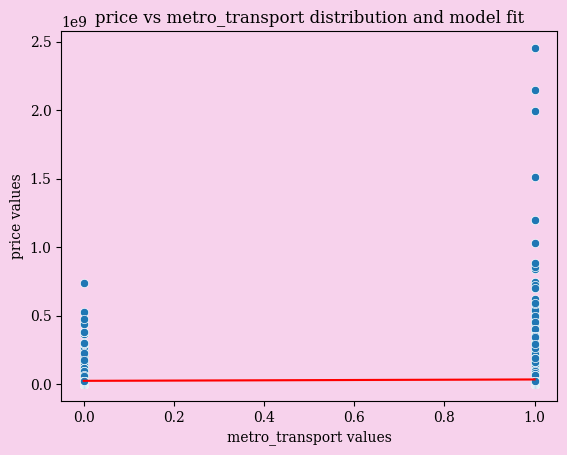

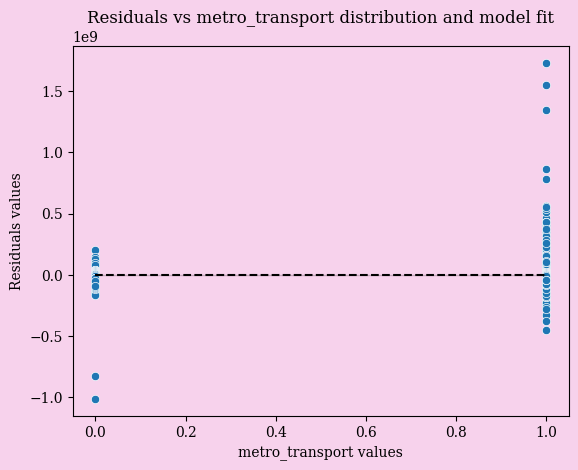

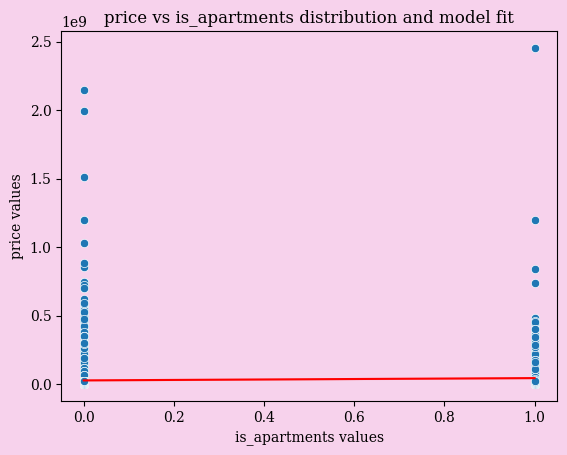

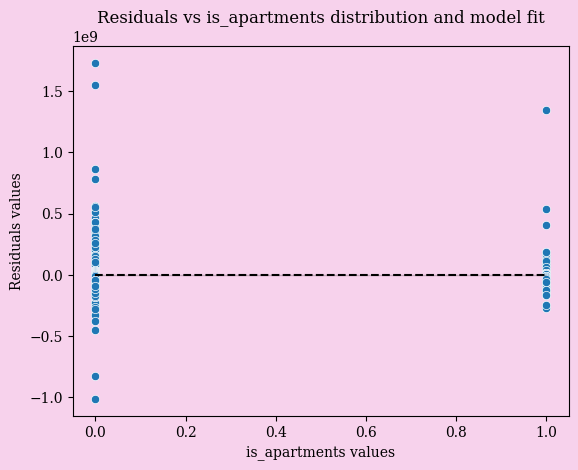

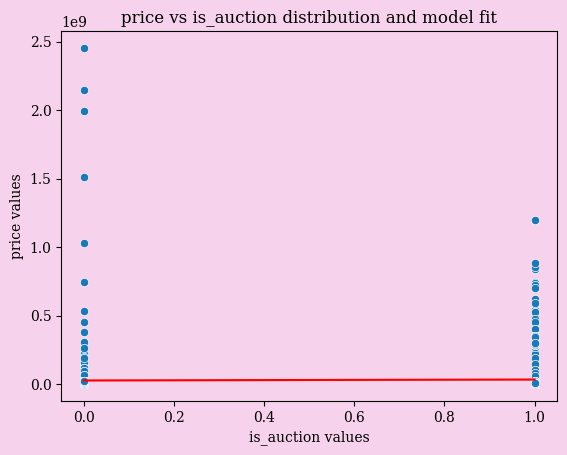

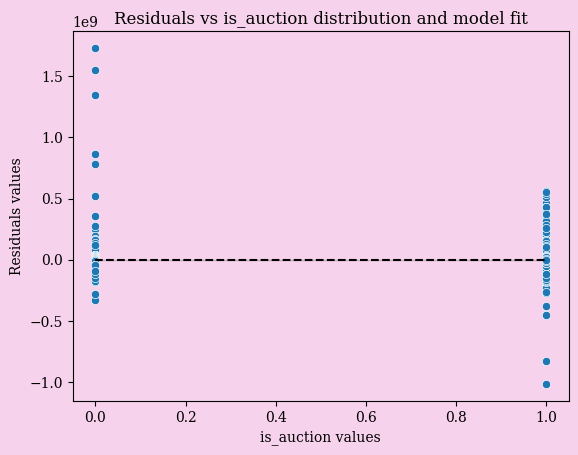

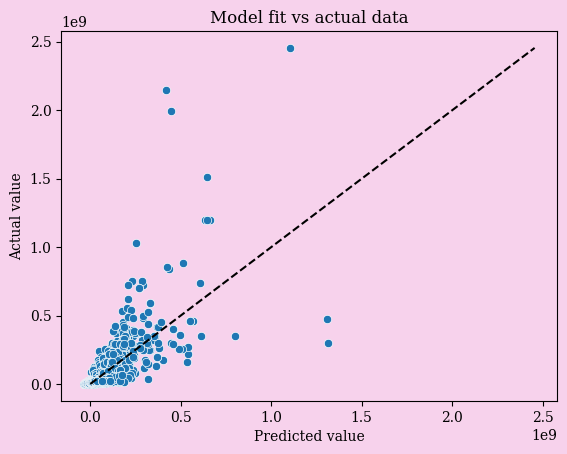

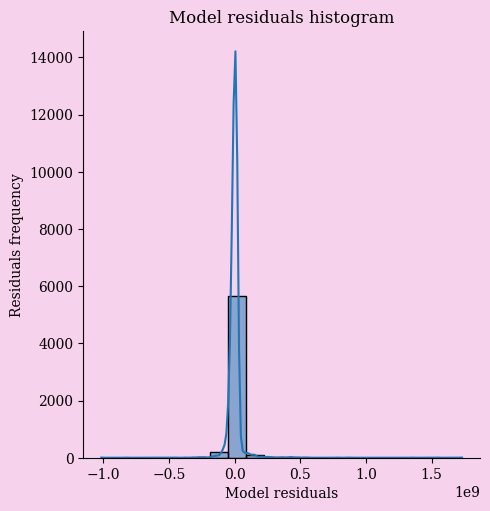

In [ ]:
features = features_

df, model_heteroskedasticity = train_model(
df, target='price', feature_names=features, show_results=True)

Тут получился очень плохой R-squared (0.55), что очень грустно и говорит нам о том, что в признаках есть определенные проблемы. Давайте перебьем некоторые категориальные признаки, изучим корреляцию между признаками и тогда выберем лучший набор.



При взгляде на репорт мы еще боьлше расстраиваемся, так как видим, что распределение остатков ну совсем не похоже на нормальное. И более того график model fit vs actual data выгладит "расходящимся" (да они тут почти все такие). Что просто кричит нам о наличии гетероскедастичности.

# Статистичка

#### Первый взгляд на датасет для статистики (была создана копия исходного, чтобы в случае чего не испортить его для дальнейшего обучения регресии)

In [ ]:
df_stat = df_stat.drop(['isСomplete', 'complitation_year', 'build_date', 'metro'],
             axis=1, errors='ignore')

In [ ]:
avg_living_area_by_rooms = df_stat.groupby('rooms_count')['living_area'].transform('mean')
df_stat['living_area'] = df_stat['living_area'].fillna(avg_living_area_by_rooms)


In [ ]:
df_stat['living_area']

0       173.300000
1       119.000000
2        50.700000
3        61.000000
4       123.800000
           ...    
5973     79.215263
5974     45.100000
5975     32.200000
5976     51.400000
5977    135.623333
Name: living_area, Length: 5978, dtype: float64

In [ ]:
df_stat.isna().sum()

region                0
address               0
price                 0
total_area            0
kitchen_area          0
living_area           0
rooms_count           0
floor                 0
floors_number         0
house_material        0
longitude             0
latitude              0
passenger_elevator    0
cargo_elevator        0
metro_distance        0
metro_transport       0
district              0
is_apartments         0
is_auction            0
center_distance       0
dtype: int64

In [ ]:
df_stat.head(3)

region                                address       price  total_area  \
0    msk  Москва, Большой Толмачёвский переулок  1996610000       459.4   
1    msk              Москва, Самотечная ул., 5    66970000       160.0   
2    msk                        Москва, Ильинка   378820000       157.4   

   kitchen_area  living_area  rooms_count  floor  floors_number  \
0          81.4        173.3          5.0      7              8   
1          25.0        119.0          3.0      3              9   
2          41.1         50.7          3.0      3              5   

  house_material  longitude   latitude  passenger_elevator  cargo_elevator  \
0       monolith  37.620949  55.739757                 1.0             1.0   
1          brick  37.618318  55.775165                 1.0             1.0   
2       monolith  37.623649  55.755140                 0.0             0.0   

   metro_distance  metro_transport      district  is_apartments  is_auction  \
0        6.666667              1.0  Якиманка,ЦАО            0.0           0   
1        9.333333              1.0  Тверской,ЦАО            0.0           1   
2        4.500000              1.0  Тверской,ЦАО            0.0           0   

   center_distance  
0         7.496010  
1         7.676473  
2         6.004669

In [ ]:
df_stat.columns

Index(['region', 'address', 'price', 'total_area', 'kitchen_area',
       'living_area', 'rooms_count', 'floor', 'floors_number',
       'house_material', 'longitude', 'latitude', 'passenger_elevator',
       'cargo_elevator', 'metro_distance', 'metro_transport', 'district',
       'is_apartments', 'is_auction', 'center_distance'],
      dtype='object')

## Распределения

In [ ]:
df_stat['price'] =np.log(df_stat['price'])

### Численные

In [ ]:
import plotly.express as px

df_stat['index'] = df_stat.index
fig = px.density_contour(df_stat, x='index', y='price', title='Распределение плотности цен по индексам',
                         labels={'price': 'Цена(млн.руб)', 'index': 'Индекс'})

fig.show()


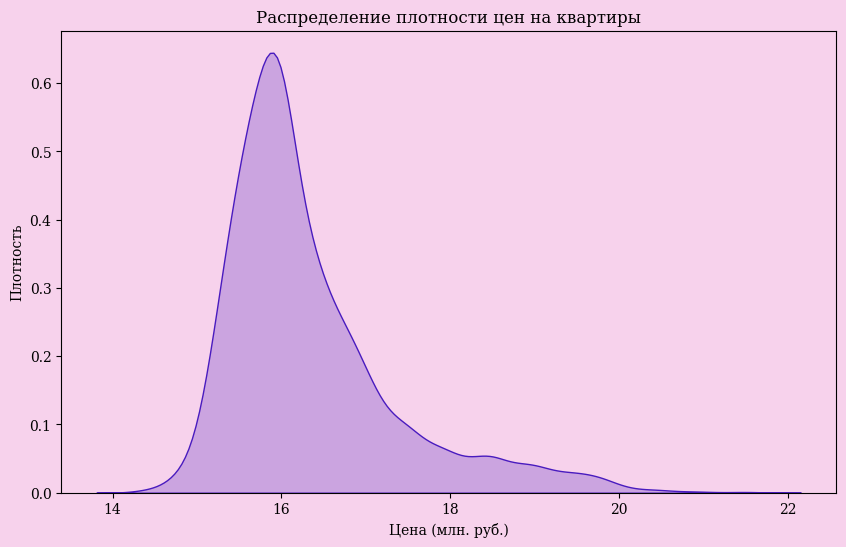

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_stat['price'], fill=True, color=fill_color)
plt.title('Распределение плотности цен на квартиры')
plt.xlabel('Цена (млн. руб.)')
plt.ylabel('Плотность')
plt.show()

Видно, что даже с учетом логарифмирования распределение цены перекошено и уж точно не является нормальным

(я не стала рисовать до логарифмирования, а то там просто был прекрасный пик огромнейший даже с учетом деления, что смотреть было очень больно)

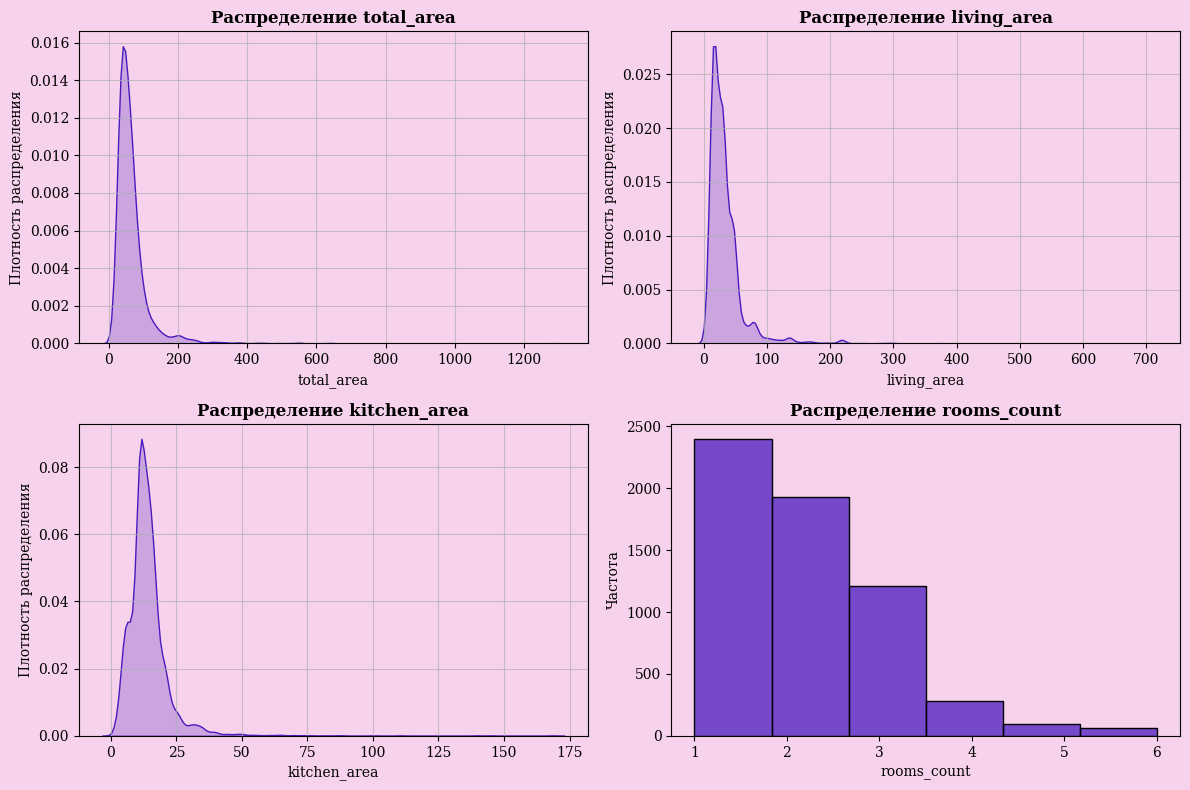

In [ ]:
plt.figure(figsize=(12, 8))
numerical_features = ['total_area', 'living_area', 'kitchen_area', 'rooms_count']
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    if feature == 'rooms_count':
        sns.histplot(df_stat[feature], kde=False, color=fill_color, bins=6)
        plt.title(f'Распределение {feature}', fontweight='bold')
        plt.ylabel('Частота')
    else:
      sns.kdeplot(df_stat[feature], fill=True, color = fill_color)
      plt.title(f'Распределение {feature}', fontweight = 'bold')
      plt.grid(alpha = 0.7)
      plt.ylabel('Плотность распределения')
plt.subplots_adjust(hspace=1.5, wspace=1.5)
plt.tight_layout()
plt.show()

In [ ]:
df_stat['total_area'] = np.log(df_stat['total_area'])
df_stat['living_area'] = np.log(df_stat['living_area'])
df_stat['kitchen_area'] = np.log(df_stat['kitchen_area'])

Прологарифмируем значения и отнормируем чтобы нам не портили жизнь слишком большие показатели

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_stat[['total_area', 'living_area', 'kitchen_area']] = scaler.fit_transform(df_stat[['total_area', 'living_area', 'kitchen_area']])


Распределения и здесь тоже максимально неровные, тоже в будущем надо будет нормирровать, иначе слишком много шума

<ipython-input-68-ba7393adcf95>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




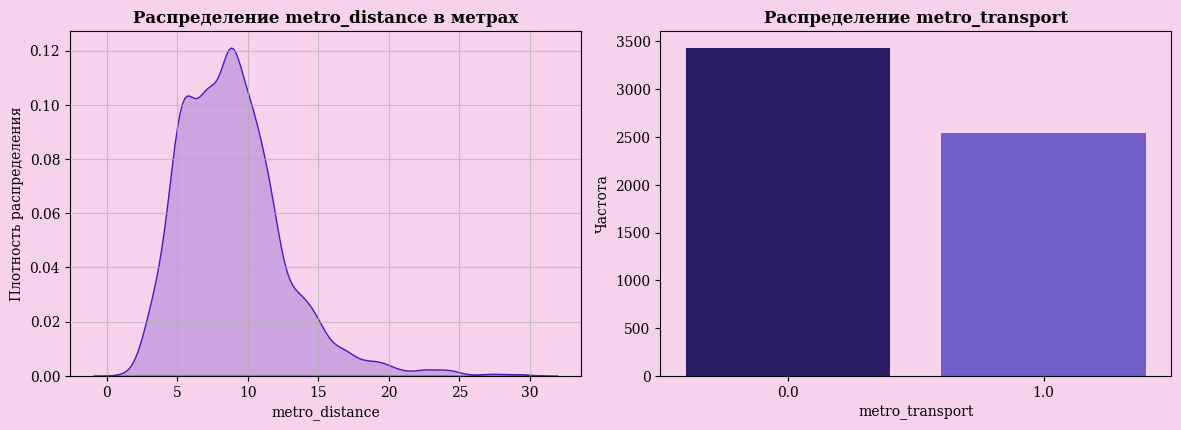

In [ ]:
plt.figure(figsize=(12, 8))
numerical_features = ['metro_distance', 'metro_transport']
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    if feature == 'metro_transport':
        sns.countplot(data=df_stat, x=feature, palette=[blue_gradient[3], blue_gradient[-2]])
        plt.title(f'Распределение {feature}', fontweight='bold')
        plt.ylabel('Частота')
    else:
      sns.kdeplot(df_stat[feature], fill=True, color = fill_color)
      plt.title(f'Распределение {feature} в метрах', fontweight = 'bold')
      plt.grid(alpha = 0.7)
      plt.ylabel('Плотность распределения')
plt.subplots_adjust(hspace=1.5, wspace=1.5)
plt.tight_layout()
plt.show()

распределение расстояния до метро в метрах тоже кривое, но чуть более "плоское"

у транспорта до метро есть легкий дисбаланс но не критичный

### Категориальные

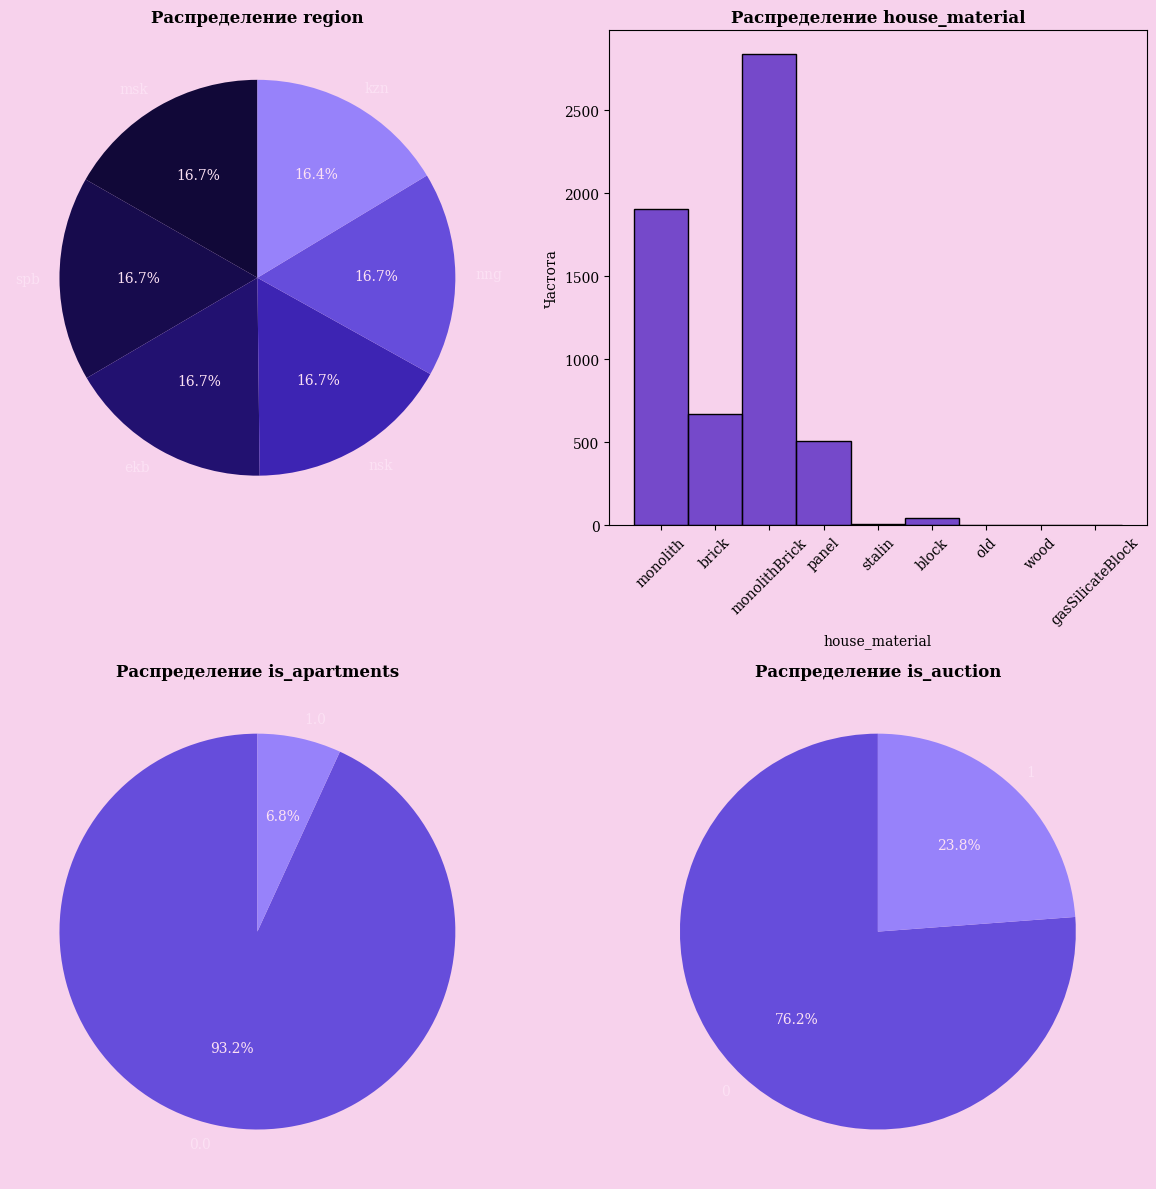

In [ ]:
import matplotlib.pyplot as plt

fill_color = fill_color
categorical_features = ['region', 'house_material', 'is_apartments', 'is_auction']
plt.figure(figsize=(12, 12))

for i, feature in enumerate(categorical_features, 1):
  plt.subplot(2, 2, i)
  data = df_stat[feature].value_counts()
  if feature == 'house_material':
    sns.histplot(df_stat[feature], kde=False, color=fill_color, discrete=True, bins=len(data))
    plt.title(f'Распределение {feature}', fontweight='bold')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
  else:
    plt.pie(data, labels=data.index, autopct='%1.1f%%', textprops= {'color': f'#fce1f4'},
            startangle=90, colors=blue_gradient[-len(data):])
    plt.title(f'Распределение {feature}', fontweight='bold')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()
plt.show()


Видно, что количество регионов примерно одинаковое, что неплохло



в распределении материалов есть сильная доминация монолитных домов- учтем это при кодировании в том или ином виде.

В датасете апартаментов очень мало, есть явный дисбаланс

аналогично и для аукциона, тоже дисбаланс, но не такой сильный как в предыдущем случае

*по поводу материалов домов я поискала информацию и там пишут, что монолит современная и недешевая технология строительства, stalin - это про Сталинские дома, у них бОльшая износоустойчивость по сравнению с другими.*

**Вывод:** мы мельком оглядели датасет, посмотрели на распределения признаков теперь будем рассматривать графики более подробно, тк применительно к гипотезам графики будут гораздо интересней. Строить просто кучу совместных распределений я не увидела смысла, постольку поскольку они не дадут никакой информации в таком случае.

In [ ]:
from scipy import stats

In [ ]:
def bootstrap_ci(sample, n_resamples=1000, ci=95):
    bootstrap_means = [np.mean(np.random.choice(sample, size=len(sample), replace=True)) for _ in range(n_resamples)]
    lower_percentile = np.percentile(bootstrap_means, (100 - ci) / 2)
    upper_percentile = np.percentile(bootstrap_means, 100 - (100 - ci) / 2)
    return lower_percentile, upper_percentile

In [ ]:
def compute_confidence_interval(data, confidence_level=0.95):
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    n = len(data)
    t_score = stats.t.ppf((1 + confidence_level) / 2, df=n - 1)

    ci = (mean - t_score * std / np.sqrt(n), mean + t_score * std / np.sqrt(n))

    return ci

## Гипотезы

#### Гипотеза 1: PSI.  Распределения total_area, kitchen_area, living_area не имеют статистических отличий

In [ ]:
def calculate_psi(expected, actual, bins=10):
    expected_perc = np.histogram(expected, bins=bins, density=True)[0]
    actual_perc = np.histogram(actual, bins=bins, density=True)[0]

    expected_perc = expected_perc + 1e-10
    actual_perc = actual_perc + 1e-10

    expected_perc /= expected_perc.sum()
    actual_perc /= actual_perc.sum()

    psi = np.sum((expected_perc - actual_perc) * np.log(expected_perc / actual_perc))
    return psi


features_to_check = ['total_area', 'living_area', 'kitchen_area']

regions = df_stat['region'].unique()

for feature in features_to_check:
  print(f'Проверка для признака: {feature}')
  for i in range(len(regions)):
    for j in range(i+1, len(regions)):
      region_1 = regions[i]
      region_2 = regions[j]

      region_1_data = df_stat[df_stat['region'] == region_1][feature]
      region_2_data = df_stat[df_stat['region'] == region_2][feature]

      psi_value = calculate_psi(region_1_data, region_2_data)
      if psi_value < 0.1:
        print(f'PSI = {psi_value:.4f} Значимых различий между {region_1} и {region_2} нет')
      elif 0.1 <= psi_value < 0.2:
        print(f'PSI = {psi_value:.4f} Требуются наблюдения за {region_1} и {region_2} ')
      else:
        print(f'PSI = {psi_value:.4f} Есть значимые различия между {region_1} и {region_2} ')
  print("-"*50)


Проверка для признака: total_area
PSI = 1.0089 Есть значимые различия между msk и spb 
PSI = 0.1503 Требуются наблюдения за msk и ekb 
PSI = 0.6033 Есть значимые различия между msk и nsk 
PSI = 0.2971 Есть значимые различия между msk и kzn 
PSI = 0.2736 Есть значимые различия между msk и nng 
PSI = 1.6238 Есть значимые различия между spb и ekb 
PSI = 0.1809 Требуются наблюдения за spb и nsk 
PSI = 1.9644 Есть значимые различия между spb и kzn 
PSI = 1.7859 Есть значимые различия между spb и nng 
PSI = 0.9058 Есть значимые различия между ekb и nsk 
PSI = 0.2733 Есть значимые различия между ekb и kzn 
PSI = 0.2333 Есть значимые различия между ekb и nng 
PSI = 1.4300 Есть значимые различия между nsk и kzn 
PSI = 1.2838 Есть значимые различия между nsk и nng 
PSI = 0.0193 Значимых различий между kzn и nng нет
--------------------------------------------------
Проверка для признака: living_area
PSI = 3.6340 Есть значимые различия между msk и spb 
PSI = 1.5599 Есть значимые различия между ms

Итак, судя по PSI индексу никакой стабильности у нас нет, только иногда есть некоторые сходства:

total area:
- PSI = 0.1503 Требуются наблюдения за msk и ekb
- PSI = 0.1809 Требуются наблюдения за spb и nsk
- PSI = 0.0193 Значимых различий между kzn и nng нет


living area:
- сходств нет

kitchen_area:
- PSI = 0.1429 Требуются наблюдения за spb и ekb

Теперь давайте визуализиурем как же у нас отличаются распределения

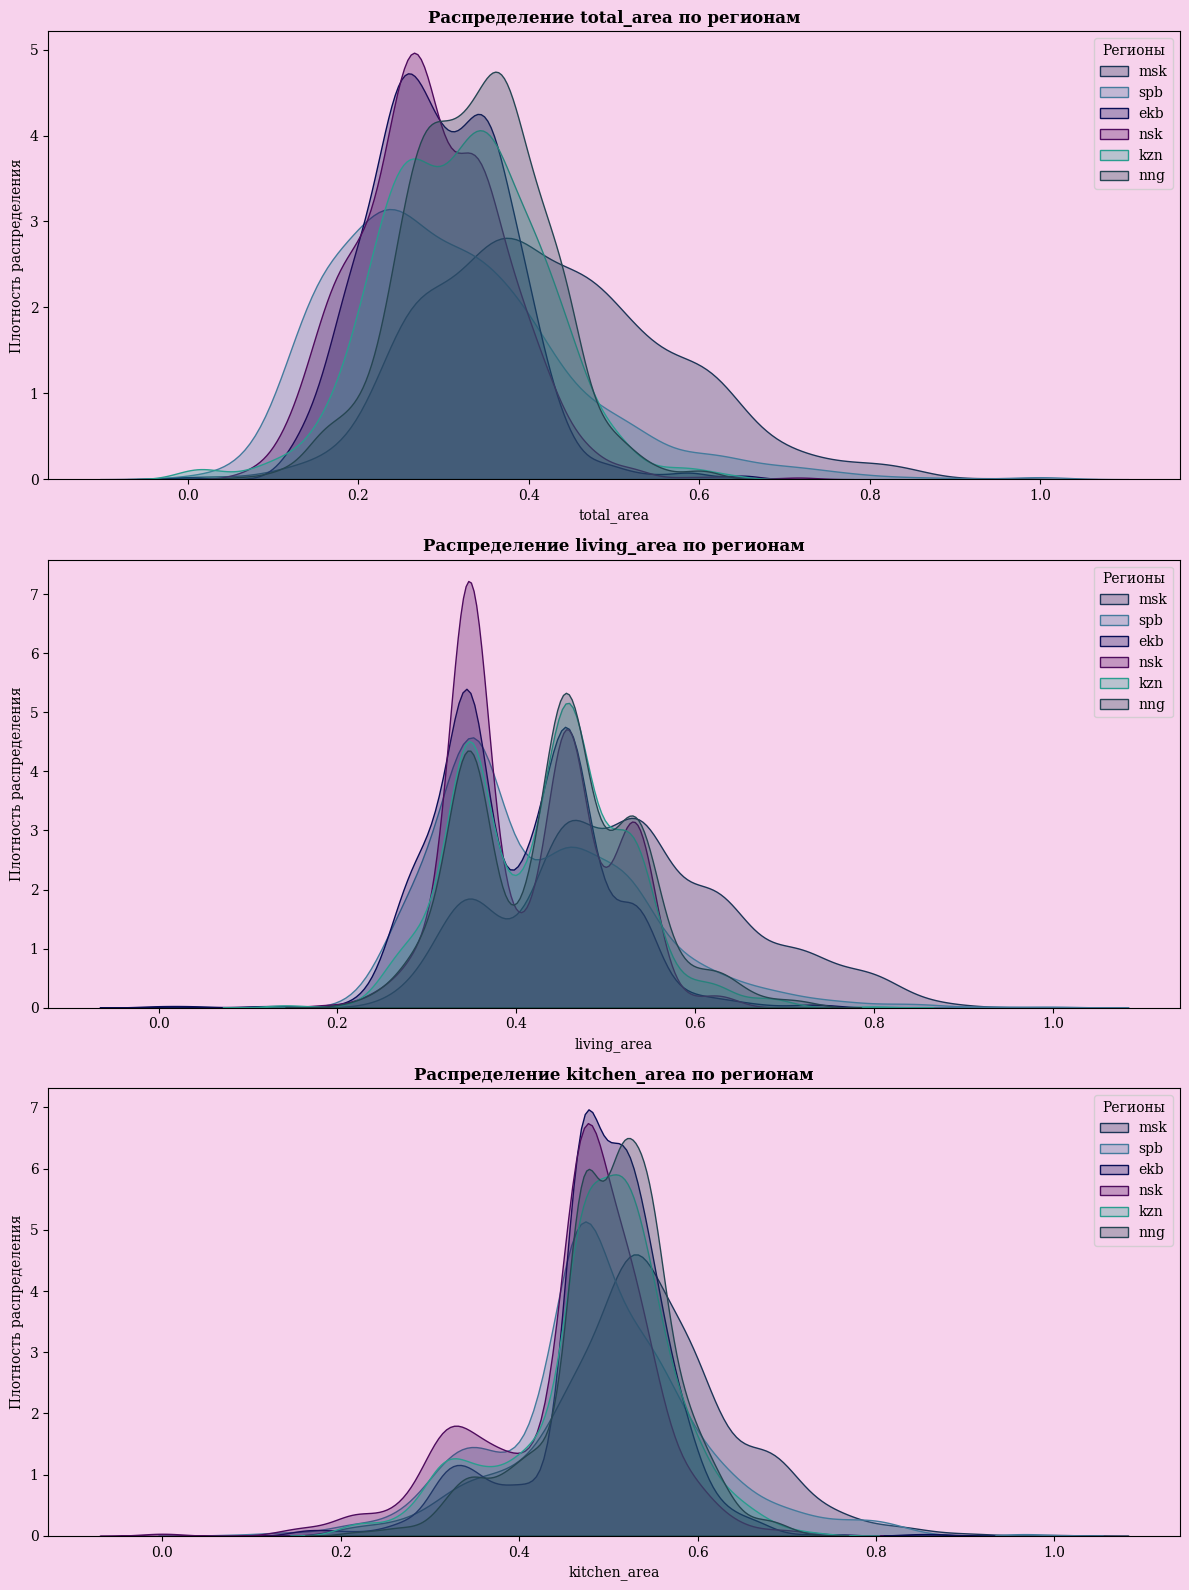

In [ ]:

features_to_check = ['total_area', 'living_area', 'kitchen_area']
regions = df_stat['region'].unique()

kde_colors =  [
    "#1D3557",
    "#457B9D",
    "#0a0e57",
    "#4f0c5e",
    "#2A9D8F",
    "#264653"
]


plt.figure(figsize=(12, 16))
for i, feature in enumerate(features_to_check, 1):
    plt.subplot(3, 1, i)
    for j, region in enumerate(regions):
        region_data = df_stat[df_stat['region'] == region][feature]
        sns.kdeplot(region_data, label=region, fill=True, alpha=0.3, color=kde_colors[j % len(kde_colors)])

    plt.title(f'Распределение {feature} по регионам', fontweight='bold')
    plt.xlabel(feature)
    plt.ylabel('Плотность распределения')
    plt.legend(title="Регионы")

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()
plt.show()

В целом то форма распределений совпадает (кроме всей площади) , но дело в том, что пики разные, поэтому PSI индекс говоит нам о том, что есть статистически значимые различия

#### Гипотеза 2: Нет разницы между площадями кнхонь в домах разного материала

In [ ]:
Q1 = df_stat['kitchen_area'].quantile(0.25)
Q3 = df_stat['kitchen_area'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_no_outliers = df_stat[(df_stat['kitchen_area'] >= lower_bound) & (df_stat['kitchen_area'] <= upper_bound)]
removed_outliers = df_stat[~df_stat.index.isin(df_no_outliers.index)]
print(f"Удалено {len(removed_outliers)} выбросов.")


Удалено 860 выбросов.


нам не особо иинтересно смотреть на разницу в деревянных домах  и сталинках, поэтому вспомним какие у нас есть материалы:

<ipython-input-76-d7e533a9a709>:6: UserWarning:


The palette list has fewer values (7) than needed (9) and will cycle, which may produce an uninterpretable plot.



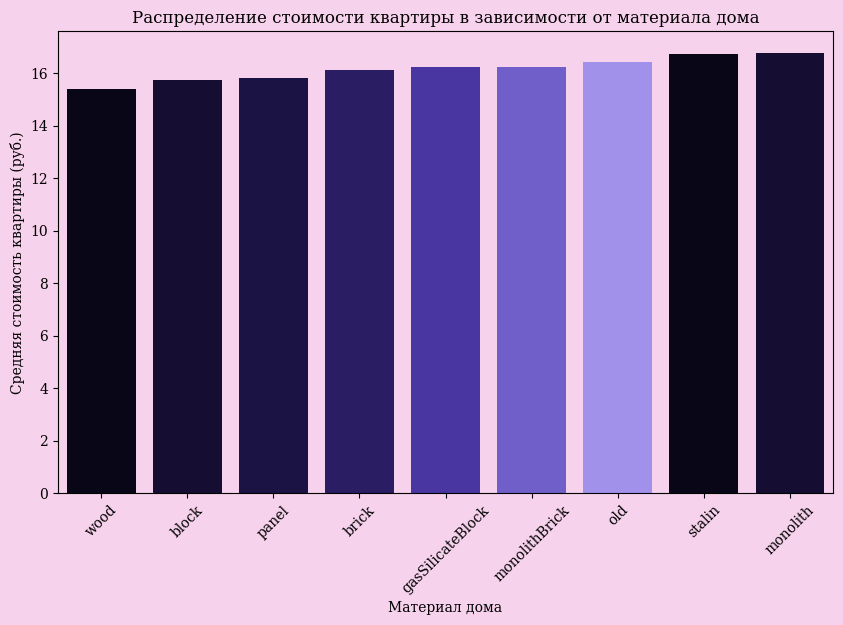

In [ ]:
avg_price_by_material = df_stat.groupby('house_material')['price'].mean().reset_index()
avg_price_by_material = avg_price_by_material.sort_values('price', ascending=True)


plt.figure(figsize=(10, 6))
sns.barplot(x='house_material', y='price',hue = 'house_material', data=avg_price_by_material, palette=blue_gradient)

plt.xlabel("Материал дома")
plt.ylabel("Средняя стоимость квартиры (руб.)")
plt.title("Распределение стоимости квартиры в зависимости от материала дома")
plt.xticks(rotation=45)

plt.show()

возбмем материалы из одного сегмента. то есть цена квартир похожа

H0: нет статистически важных различий между плозадми кухон в домах из этой группы материала

H1: различия есть

p-value = 0.05

До этого мы выяснили что распределение площадей не супер нормальное, поэтому ANOVA нам не подойдет, используем тест Краскелла - Уоллиса


In [ ]:
materials  = ['brick', 'monolithBrick', 'panel']

grouped_data = [df_stat[df_stat['house_material'] == material]['kitchen_area']
                for material in materials]

stat, p_value = stats.kruskal(*grouped_data)

print(f"Статистика: {stat}")
print(f"p-значение: {p_value}")

Статистика: 232.77208474686745
p-значение: 2.845666666389361e-51


Так, p-value<0.05, то есть у нас есть различия между площадями кухонь. Приняли альтернативную гипотезу.

Теперь определим где же есть различия с помощью теста Манна Уитни

In [ ]:
for i in range(len(materials)):
  for j in range(i+1, len(materials)):
    material_1 = materials[i]
    material_2 = materials[j]

    data_1 = df_stat[df_stat['house_material'] == material_1]['kitchen_area']
    data_2 = df_stat[df_stat['house_material'] == material_2]['kitchen_area']

    stat_mw, p_value_mw = stats.mannwhitneyu(data_1, data_2)
    print(f"Сравнение {material_1} и {material_2}: статистика = {stat_mw}, p-значение = {p_value_mw}")

    if p_value_mw < 0.05:
      print(f"Есть статистически значимые различия между {material_1} и {material_2}.")
    else:
      print(f"Нет статистически значимых различий между {material_1} и {material_2}.")

Сравнение brick и monolithBrick: статистика = 687968.0, p-значение = 1.8144957560410774e-29
Есть статистически значимые различия между brick и monolithBrick.
Сравнение brick и panel: статистика = 174973.0, p-значение = 0.36641027586597863
Нет статистически значимых различий между brick и panel.
Сравнение monolithBrick и panel: статистика = 959093.5, p-значение = 8.935289143661624e-34
Есть статистически значимые различия между monolithBrick и panel.


Визуализируем распределение, чтобы понять в какую сторону у нас различия

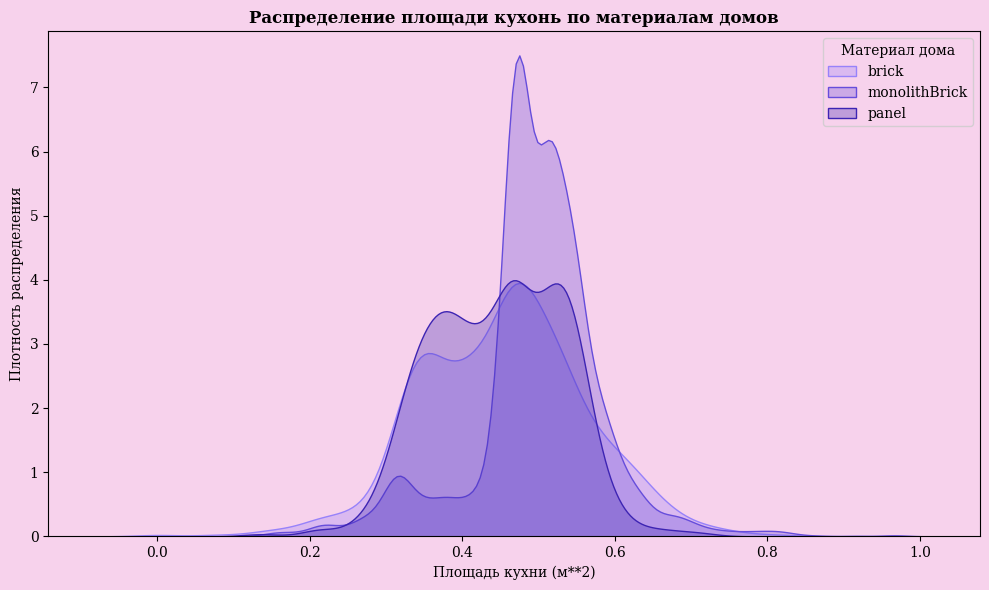

In [ ]:
plt.figure(figsize=(10, 6))

for i, material in enumerate(materials):
    material_data = df_stat[df_stat['house_material'] == material]['kitchen_area']
    sns.kdeplot(material_data, label=material, fill=True, alpha=0.3, color=blue_gradient[-i-1])

# Добавляем заголовок и подписи
plt.title('Распределение площади кухонь по материалам домов', fontweight='bold')
plt.xlabel('Площадь кухни (м**2)')
plt.ylabel('Плотность распределения')
plt.legend(title="Материал дома")
plt.tight_layout()
plt.show()

Группа Монолит - кирпич выбивается вперед.

Почему такое могло произойти?

- Более большая выборка
- Есть выбросы

- Более современная технология (в более новых домах кухни больше чем в панельных)


Как вариант, можно попробовать брать здания из примерно одного периода постройки (но мне к сожалению не удалось это сделать, тк не получилось восстановить признак)


In [ ]:
ci_s =[]
bootstrap_ci_s =[]

for material in materials:
  material_data = df_stat[df_stat['house_material'] == material]['kitchen_area']
  ci = compute_confidence_interval(material_data)
  ci_bootsrtap = bootstrap_ci(material_data)
  bootstrap_ci_s.append(ci_bootsrtap)
  ci_s.append(ci)

int_s = pd.DataFrame({
    'materian': materials,
    'ci_lower': [ci[0] for ci in ci_s],
    'ci_upper': [ci[1] for ci in ci_s],
    'bootstrap_ci_lower': [ci_bootstrap[0] for ci_bootstrap in bootstrap_ci_s],
    'bootstrap_ci_upper': [ci_bootstrap[1] for ci_bootstrap in bootstrap_ci_s]
})
print(int_s)

        materian  ci_lower  ci_upper  bootstrap_ci_lower  bootstrap_ci_upper
0          brick  0.444841  0.461112            0.444842            0.460842
1  monolithBrick  0.493876  0.500244            0.493883            0.500115
2          panel  0.439004  0.453819            0.439075            0.454026


Доверительный интервал достаточно узкий для монолит кирпича. Тк для него больше всего данных.

У кирпича и панелей интервалы шире, так как там гораздо меньше набоюдений.

Интересно, но бутстрап выдал более точный результат.

#### Гипотеза 3: Квартиры ближе к центру города стоят дороже

In [ ]:
df_stat.columns

Index(['region', 'address', 'price', 'total_area', 'kitchen_area',
       'living_area', 'rooms_count', 'floor', 'floors_number',
       'house_material', 'longitude', 'latitude', 'passenger_elevator',
       'cargo_elevator', 'metro_distance', 'metro_transport', 'district',
       'is_apartments', 'is_auction', 'center_distance', 'index'],
      dtype='object')

H0: Стоимость квартир одинаковая

H1: Стоимость разная

In [ ]:
edge = np.log(5000)

closer_to_center = df_stat[df_stat['center_distance'] <= edge]
further_from_center = df_stat[df_stat['center_distance'] > edge]
sts,p_velue = stats.mannwhitneyu(closer_to_center['price'], further_from_center['price'])
print(f"Статистика: {sts}")
print(f"p-значение: {p_velue}")

Статистика: 5076542.0
p-значение: 3.06283628155277e-51


p-value < 0.05 значит отвергаем нулевую гипотезу и можем сделать вывод, что удаленность от центра влияет на стоимость квартиры (возьмем на заметку для подбора регрессеров дальше)

проведем то же самое, но по регионам. Может результат получится другой?

In [ ]:
regions = df_stat['region'].unique()
print(regions)

edges = np.array([7000, 5000, 4000, 3000, 3500, 3000])
edges = np.log(edges)

for i, region in enumerate(regions):
  region_data = df_stat[df_stat['region'] == region]

  closer_to_center = region_data[region_data['center_distance'] <= edges[i]]
  further_from_center = region_data[region_data['center_distance'] > edges[i]]

  sts,p_velue = stats.mannwhitneyu(closer_to_center['price'], further_from_center['price'])
  if p_velue >= 0.05:
    print(f"Регион: {region}, Стоимость не отличается, p-значение: {p_velue}")
  else:
    print(f"Регион: {region}, Есть статистически значимые различия, p-значение: {p_velue}")

['msk' 'spb' 'ekb' 'nsk' 'kzn' 'nng']
Регион: msk, Есть статистически значимые различия, p-значение: 4.697785492521961e-43
Регион: spb, Есть статистически значимые различия, p-значение: 9.929030735642701e-34
Регион: ekb, Есть статистически значимые различия, p-значение: 3.875403547036082e-17
Регион: nsk, Есть статистически значимые различия, p-значение: 2.0825694740483856e-14
Регион: kzn, Стоимость не отличается, p-значение: 0.1625185255012881
Регион: nng, Есть статистически значимые различия, p-значение: 0.000247141583817254


Отличия есть только в Казани, там стоимость квартир не отличается

С чем может быть связано:


- престижность района. Возможно, в Казани центральная часть не самая престижная в плане жилья
- Может быть в казани хорошая транспортная доступность, что не делает жизнь ближе к центру комфортней
- центры досуга/офисы могут располагаться не в центре. Как правило, не все люди хотят жить очень далеко от таких мест
- откуда вытекает следующий вопрос - может быть в казани хорошо развит досуг в каждом районе, что нет нужны выбираться в центр, в следствие чего задумываться о покупке жилья там


- также возможно, что в центре города очень старое жилье.

здесь может помочь: реставрация зданий, капитальный ремонт, снос аварийных зданий (что повысит уровень района в глазах жителей)

In [ ]:
ci = []
boostrap_ci =[]
regions = df_stat['region'].unique()


for region in regions:
  region_data = df_stat[df_stat['region'] == region]
  if region == 'msk':
    edge = np.log(8000)

  closer_to_center = region_data[region_data['metro_distance'] <= edge]
  further_from_center = region_data[region_data['metro_distance'] > edge]

  ci_closer = compute_confidence_interval(closer_to_center['price'])
  ci_further = compute_confidence_interval(further_from_center['price'])

  ci.append({
        'region': region,
        'ci_closer_lower': ci_closer[0],
        'ci_closer_upper': ci_closer[1],
        'ci_further_lower': ci_further[0],
        'ci_further_upper': ci_further[1]
    })

  ci_closer_bootstrap = bootstrap_ci(closer_to_center['price'])
  ci_further_bootstrap = bootstrap_ci(further_from_center['price'])
  boostrap_ci.append({
        'region': region,
        'ci_closer_lower__b': ci_closer[0],
        'ci_closer_upper_b': ci_closer[1],
        'ci_further_lower_b': ci_further[0],
        'ci_further_upper_b': ci_further[1]
    })

ci_df = pd.DataFrame(ci)
bootstrap_ci_df = pd.DataFrame(boostrap_ci)

res = pd.merge(ci_df, bootstrap_ci_df, on='region', suffixes=('_ci', '_bootstrap_ci'))
print(res)


  region  ci_closer_lower  ci_closer_upper  ci_further_lower  \
0    msk        17.797240        17.990114         17.807538   
1    spb        16.370957        16.548895         16.251035   
2    ekb        15.714728        15.768574         15.722021   
3    nsk        15.727388        15.798963         15.498704   
4    kzn        16.234020        16.306782         15.937493   
5    nng        16.112606        16.193330         16.104077   

   ci_further_upper  ci_closer_lower__b  ci_closer_upper_b  \
0         17.990805           17.797240          17.990114   
1         16.405763           16.370957          16.548895   
2         15.814600           15.714728          15.768574   
3         15.568824           15.727388          15.798963   
4         16.082290           16.234020          16.306782   
5         16.195890           16.112606          16.193330   

   ci_further_lower_b  ci_further_upper_b  
0           17.807538           17.990805  
1           16.251035       

## Выводы по блоку

Выводы: в данных больше шума чем я думала, значит надо уделить внимание нормализации некоторых признаков (помогло с ценой, расстоянием, площадями). Графики распределения признаков помогли увидеть, смещения.

Проверка некоторых гипотез позволила понять:
1. разных регионах разные распределения площадей квартир (вот тут заложна корреляция между region_recoded и признаками площади и тп. Убедилась, что регион в регрессоры включать не стоит)

2. В регрессии надо оттолкнуться от признака center distance, возможно он поможет в создании других признаков.



# Регрессия Но умнее

In [ ]:
# df['price'] /= 10**6
df['price'] = np.log(df['price'])

## Далее попытаемся побороться с тем, что наивная модель оказалась печальной


---

Варианты что делать:

1. Кажется у нас есть категориальные признаки, которые потенциально могут повлиять на таргет переменну - цену. Перекодируем их. (материал дома, регион, район)
2. Большая корреляция между некоторыми другими признаками. Попробуем некоторые объединить, создать новые признаки, которые будут в идеале меньше коррелировать друг с другом, но будут иметь влияние на цену.
3. По графикам видно, что есть большой шум в данных, попробуем его уменьшить, отнормировав данные (логарифмируем, просто скейлим)

#### Перекодируем материал

<ipython-input-86-64bf2ad2453b>:6: UserWarning:


The palette list has fewer values (7) than needed (9) and will cycle, which may produce an uninterpretable plot.



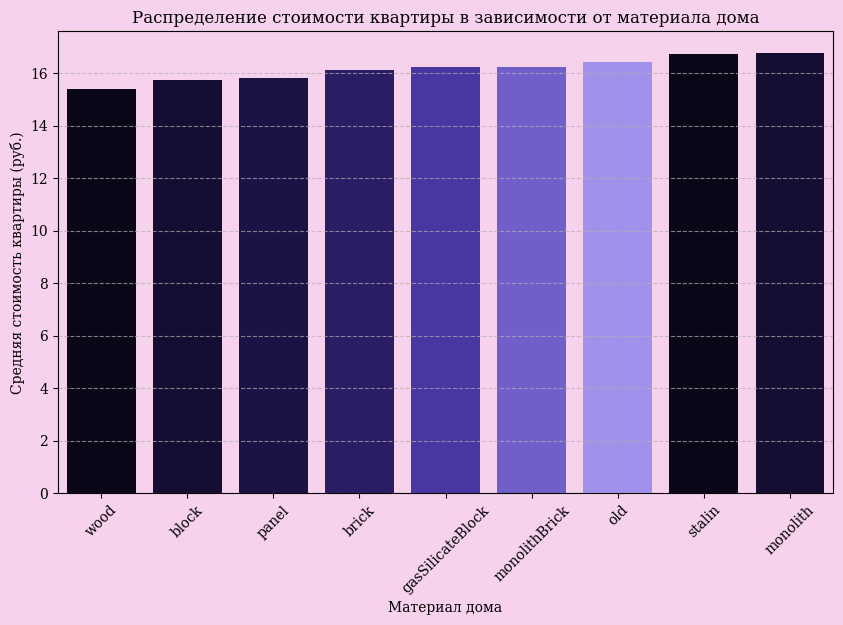

In [ ]:
avg_price_by_material = df.groupby('house_material')['price'].mean().reset_index()
avg_price_by_material = avg_price_by_material.sort_values('price', ascending=True)


plt.figure(figsize=(10, 6))
sns.barplot(x='house_material', y='price',hue = 'house_material', data=avg_price_by_material, palette=blue_gradient)

plt.xlabel("Материал дома")
plt.ylabel("Средняя стоимость квартиры (руб.)")
plt.title("Распределение стоимости квартиры в зависимости от материала дома")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

этот график показал что квартиры из определенных материалов дороже

In [ ]:
# вспомним что у нас с материалами домов
df['house_material'].unique()

array(['monolith', 'brick', 'monolithBrick', 'panel', 'stalin', 'block',
       'old', 'wood', 'gasSilicateBlock'], dtype=object)

вот так и заполним: то что лучше = цифра меньше

In [ ]:
material_qualities = {
    'monolith': 3,
    'stalin': 3,
    'monolithBrick': 2,
    'old': 2,
    'brick': 2,
    'gasSilicateBlock': 2
}

In [ ]:
df['house_material'] = df['house_material'].map(material_qualities).fillna(1).astype(int)

#### Нормируем по квартирам

<ipython-input-90-80b7380b8e65>:4: UserWarning:

The palette list has more values (7) than needed (6), which may not be intended.



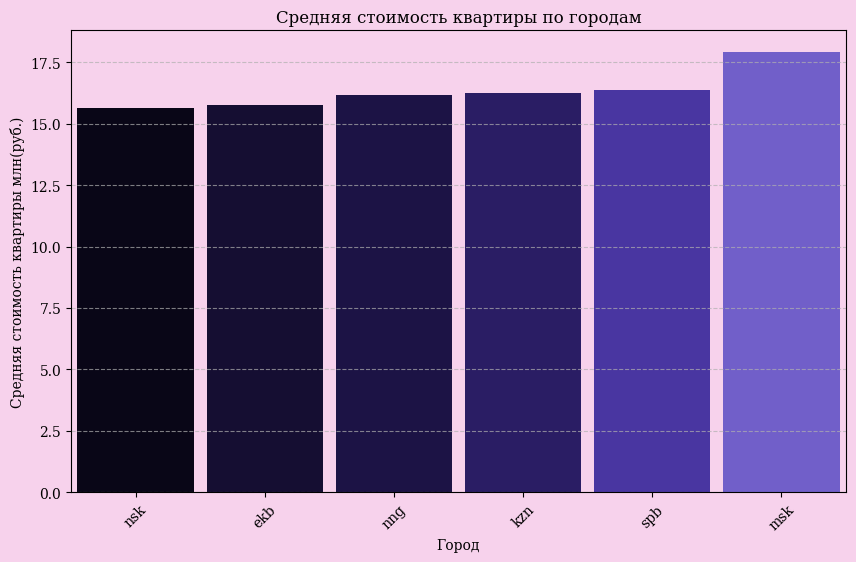

In [ ]:
avg_price_by_city = df.groupby('region')['price'].mean().reset_index()
avg_price_by_city = avg_price_by_city.sort_values('price', ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='price',
            hue='region',
            data=avg_price_by_city, palette=blue_gradient,
            width=0.9)
plt.xlabel("Город")
plt.ylabel("Средняя стоимость квартиры млн(руб.)")
plt.title("Средняя стоимость квартиры по городам")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
df = df[df['floor']>=0]

In [ ]:
print(df.columns)


Index(['region', 'address', 'price', 'total_area', 'kitchen_area',
       'rooms_count', 'floor', 'floors_number', 'house_material', 'longitude',
       'latitude', 'passenger_elevator', 'cargo_elevator', 'metro_distance',
       'metro_transport', 'district', 'is_apartments', 'is_auction',
       'center_distance', 'price_hat', 'residuals'],
      dtype='object')


In [ ]:
len(df)

5977

In [ ]:
df['price']/= 10**6

<ipython-input-94-ce2e75736057>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Перекодируем регион

регион кодировали по стоимости квартиры в нем

In [ ]:
region_mapping = {
    'msk': 6,
    'spb': 5,
    'kzn': 4,
    'nng': 3,
    'ekb': 2,
    'nsk': 1
}

df['region_recoded'] = df['region'].map(region_mapping).fillna(1).astype(int)


<ipython-input-95-66450abd73ea>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Перекодируем районы по стоимости квартиры

создали вот такой списочек, чтобы удобно из df смотреть что у нас происходит)

In [ ]:
check_coding = ['address', 'district', 'district_recoded']


######  Москва

In [ ]:
df_msk = df[df['region'] == 'msk']

In [ ]:
len(df)

5977

In [ ]:
len(df_msk)

1000

In [ ]:
# Считаем среднюю цену для каждого района
average_price_by_district = df_msk.groupby('district')['price'].mean()

# Нормализуем цену для каждого района в диапазоне от 1 до 10
min_price = average_price_by_district.min()
max_price = average_price_by_district.max()

# Создаём новый словарь на основе нормализованных цен
prestige_dict = {
    district: round(1 + (price - min_price) / (max_price - min_price) * 9)
    for district, price in average_price_by_district.items()
}

# Преобразуем в целые числа, ограничиваем диапазон от 1 до 10
prestige_dict = {k: min(max(v, 1), 10) for k, v in prestige_dict.items()}

print(prestige_dict)


{'17-й,Крюково,ЗелАО': 4, 'Академический,ЮЗАО': 6, 'Алексеевский,СВАО': 5, 'Арбат,ЦАО': 9, 'Аэропорт,САО': 5, 'Басманный,ЦАО': 7, 'Беговой,САО': 7, 'Богородское,ВАО': 4, 'Братеево,ЮАО': 4, 'Бутырский,СВАО': 3, 'Вешняки,ВАО': 3, 'Воскресенское,НАО (Новомосковский)': 3, 'Восточное Измайлово,ВАО': 1, 'Выхино-Жулебино,ЮВАО': 3, 'Гагаринский,ЮЗАО': 7, 'Головинский,САО': 6, 'Гольяново,ВАО': 2, 'Град Московский,Московский,НАО (Новомосковский)': 3, 'Даниловский,ЮАО': 6, 'Десёновское,НАО (Новомосковский)': 2, 'Дмитровский,САО': 3, 'Донской,ЮАО': 6, 'Дорогомилово,ЗАО': 7, 'ЗАО': 6, 'Замоскворечье,ЦАО': 7, 'Западное Дегунино,САО': 5, 'Измайлово,ВАО': 5, 'Кокошкино,НАО (Новомосковский)': 3, 'Коньково,ЮЗАО': 6, 'Коптево,САО': 4, 'Котловка,ЮЗАО': 4, 'Красносельский,ЦАО': 7, 'Крылатское,ЗАО': 8, 'Кунцево,ЗАО': 5, 'Лефортово,ЮВАО': 5, 'Ломоносовский,ЮЗАО': 8, 'Люблино,ЮВАО': 4, 'Марфино,СВАО': 5, 'Марьина роща,СВАО': 6, 'Метрогородок,ВАО': 4, 'Мещанский,ЦАО': 9, 'Митино,СЗАО': 4, 'Можайский,ЗАО': 5, '

In [ ]:
prestige_dict = {
    'ЦАО': 10,
    'ЗАО': 9,
    'САО': 8,
    'ЮЗАО': 7,
    'ЮАО': 6,
    'СЗАО': 5,
    'ВАО': 4,
    'ЮВАО': 3,
    'СВАО': 2,
    'ТиНАО': 1
}


In [ ]:
df['ao'] = df['district'].str.split(',').str[-1]

In [ ]:
df['ao'] = df['district'].str.split(',').str[-1]
df.loc[df['region'] == 'msk', 'district_recoded'] = df.loc[df['region'] == 'msk', 'ao'].map(prestige_dict)
df.loc[(df['region'] == 'msk') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)

In [ ]:
df['district_recoded'].isna().sum()

np.int64(4977)

In [ ]:
df[check_coding].sample(10)

address  \
4848  Республика Татарстан, Казань, улица Сабира Ахт...   
3973                     Новосибирск, улица Королёва, 4   
1471  Санкт-Петербург, Петроградский район, 1-я Берё...   
2551  Свердловская область, Екатеринбург, микрорайон...   
939                      Москва, ул. Долгопрудная д.6к2   
1920  Санкт-Петербург, Санкт-Петербург, Дальневосточ...   
441             Россия, Москва, улица Маросейка, 11/4с1   
2836  Свердловская область, Екатеринбург, улица Очер...   
409                   Москва, Кутузовский проезд, 16А/1   
5060              Нижний Новгород, Арктический переулок   

                               district  district_recoded  
4848                          Советский               NaN  
3973                        Дзержинский               NaN  
1471           Чкаловское,Петроградский               NaN  
2551  Старая Сортировка,Железнодорожный               NaN  
939                     Дмитровский,САО               8.0  
1920                    Невский,Невский               NaN  
441                       Басманный,ЦАО              10.0  
2836                      Академический               NaN  
409                    Дорогомилово,ЗАО               9.0  
5060                Молитовка,Ленинский               NaN

###### Новосибирск

In [ ]:
df_nsk = df[df['region'] == 'nsk']
len(df_nsk)

1000

In [ ]:
nsk_districts_rating = {
    'Железнодорожный': 10,
    'Заельцовский': 9,
    'Центральный': 8,
    'Первомайский': 7,
    'Советский': 6,
    'Октябрьский': 5,
    'Калининский': 4,
    'Дзержинский': 3,
    'Кировский': 2,
    'Ленинский': 1
}


In [ ]:
df['ao'] = df['district'].str.split(',').str[-1]
df.loc[df['region'] == 'nsk', 'district_recoded'] = df.loc[df['region'] == 'nsk', 'ao'].map(nsk_districts_rating)
df.loc[(df['region'] == 'nsk') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)

In [ ]:
df['district_recoded'].isna().sum()

np.int64(3977)

In [ ]:
df_nsk = df[df['region'] == 'nsk']
df_nsk[check_coding].sample(10)

address  \
3940                   Новосибирск, улица Лескова, 17/1   
3815                        Новосибирск, улица Бородина   
3009  Новосибирск, Ленинский район, микрорайон Горск...   
3939               Новосибирск, Красный проспект, 167к9   
3487  Россия, Новосибирская область, город Новосибир...   
3707                   Новосибирск, улица Забалуева, с9   
3851                       Новосибирск, улица Юности, 7   
3567                   Новосибирск, улица Забалуева, 96   
3761             Новосибирск, улица Коминтерна, 120с6/1   
3524                Новосибирск, улица Забалуева, 102/1   

                    district  district_recoded  
3940             Октябрьский               5.0  
3815               Кировский               2.0  
3009       Горский,Ленинский               1.0  
3939            Заельцовский               9.0  
3487               Ленинский               1.0  
3707               Ленинский               1.0  
3851  Дивногорский,Ленинский               1.0  
3567               Ленинский               1.0  
3761             Дзержинский               3.0  
3524               Ленинский               1.0

###### Нижний новгород

In [ ]:
df_nng = df[df['region'] == 'nng']

In [ ]:
nng_districts_rating = {
    'Центральный': 10,
    'Ленинский': 9,
    'Автозаводский': 8,
    'Московский': 7,
    'Канавинский': 6,
    'Сормовский': 5,
    'Нижегородский': 4,
    'Советский': 3,
    'Приокский': 2,
    'Северный': 1
}


df['district'] = df['district'].str.strip()
df['ao'] = df['district'].str.split(',').str[-1].str.strip()
df.loc[df['region'] == 'nng', 'district_recoded'] = df.loc[df['region'] == 'nng', 'ao'].map(nng_districts_rating)
df.loc[(df['region'] == 'nng') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)

In [ ]:
df['district_recoded'].isna().sum()

np.int64(2977)

In [ ]:
df_nng = df[df['region'] == 'nng']
df_nng[check_coding].sample(10)

address  \
5521  Нижегородская область, городской округ Нижний ...   
5831                     Нижний Новгород, улица Баумана   
5872                  Нижний Новгород, Барминская улица   
5320              Нижний Новгород, Арктический переулок   
5975          Нижний Новгород, Краснозвёздная улица, 10   
5733                  Нижний Новгород, улица Белинского   
5449                  Нижний Новгород, улица Менделеева   
5841      Нижний Новгород, улица Владимира Высоцкого, 1   
5181  Нижегородская область, Нижний Новгород городск...   
5075          Нижний Новгород, улица Лесной Городок, 7Б   

                          district  district_recoded  
5521               6,Автозаводский               8.0  
5831           Молитовка,Ленинский               9.0  
5872           Центр,Нижегородский               4.0  
5320           Молитовка,Ленинский               9.0  
5975  Тобольские казармы,Советский               3.0  
5733            Высоково,Советский               3.0  
5449        Ленгородок,Канавинский               6.0  
5841                 Нижегородский               4.0  
5181        Северный,Автозаводский               8.0  
5075     Сортировочный,Канавинский               6.0

###### Екатеринбург

In [ ]:
df_ekb = df[df['region'] == 'ekb']

In [ ]:
ekb_districts_rating = {
    'Центральный': 10,
    'Верх-Исетский': 9,
    'Чкаловский': 8,
    'Ленинский': 7,
    'Октябрьский': 6,
    'Кировский': 5,
    'Орджоникидзевский': 4,
    'Железнодорожный': 3,
    'Березовский': 2,
    'Свердловский': 1
}

df['district'] = df['district'].str.strip()
df['ao'] = df['district'].str.split(',').str[-1].str.strip()
df.loc[df['region'] == 'ekb', 'district_recoded'] = df.loc[df['region'] == 'ekb', 'ao'].map(ekb_districts_rating)
df.loc[(df['region'] == 'ekb') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)

In [ ]:
df_ekb = df[df['region'] == 'ekb']
df_ekb[check_coding].sample(10)

address  \
2283  Свердловская область, Екатеринбург, улица 8 Ма...   
2537  Свердловская область, Екатеринбург, Рощинская ...   
2540  Свердловская область, Екатеринбург, Черкасская...   
2064  620137, Свердловская обл, г Екатеринбург, Киро...   
2410  Свердловская область, Екатеринбург, Московская...   
2817  Свердловская область, Екатеринбург, улица Амун...   
2419  Свердловская область, Екатеринбург, Октябрьски...   
2026  Свердловская область, Екатеринбург, Вознесенск...   
2461  Свердловская область, Екатеринбург, улица Виль...   
2926  Свердловская область, Екатеринбург, улица Крас...   

                        district  district_recoded  
2283     Ботанический,Чкаловский               8.0  
2537            Уктус,Чкаловский               8.0  
2540  Юго-Западный,Верх-Исетский               9.0  
2064        Пионерский,Кировский               5.0  
2410      Юго-Западный,Ленинский               7.0  
2817                   Ленинский               7.0  
2419    Птицефабрика,Октябрьский               6.0  
2026                       Центр               1.0  
2461               Академический               1.0  
2926               УНЦ,Ленинский               7.0

###### Питер

In [ ]:
df_spb = df[df['region'] == 'spb']

In [ ]:
spb_districts_rating = {
    'Центральный': 10,
    'Петроградский': 9,
    'Приморский': 8,
    'Красногвардейский': 7,
    'Василеостровский': 6,
    'Адмиралтейский': 5,
    'Калининский': 4,
    'Невский': 3,
    'Фрунзенский': 2,
    'Московский': 1
}


df['district'] = df['district'].str.strip()
df['ao'] = df['district'].str.split(',').str[-1].str.strip()
df.loc[df['region'] == 'spb', 'district_recoded'] = df.loc[df['region'] == 'spb', 'ao'].map(spb_districts_rating)
df.loc[(df['region'] == 'spb') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)

In [ ]:
df_spb = df[df['region'] == 'spb']
df_spb[check_coding].sample(10)

address  \
1200      Россия, Санкт-Петербург, Введенская улица, 17   
1020      Санкт-Петербург, улица Шкапина, 43-45, лит. А   
1553             Санкт-Петербург, Планерная улица, 87к1   
1274         Санкт-Петербург, Петровский проспект, 11к3   
1806  г Санкт-Петербург, Гражданский пр-кт, д 9 к 8 ...   
1531  Россия, Санкт-Петербург, набережная реки Смоле...   
1795  Россия, Санкт-Петербург, посёлок Парголово, За...   
1284  Санкт-Петербург, Петроградский район, 1-я Берё...   
1625      Санкт-Петербург, проспект Ленинский,дом 111к2   
1853  Россия, Санкт-Петербург город, территория Усть...   

                                 district  district_recoded  
1200             Введенский,Петроградский               9.0  
1020       Екатерингофский,Адмиралтейский               5.0  
1553                  Юнтолово,Приморский               8.0  
1274             Петровский,Петроградский               9.0  
1806                Гражданка,Калининский               4.0  
1531  Остров Декабристов,Василеостровский               6.0  
1795                 Парголово,Выборгский               1.0  
1284             Чкаловское,Петроградский               9.0  
1625                     Дачное,Кировский               1.0  
1853                     Рыбацкое,Невский               3.0

###### Казань

In [ ]:
df_kzn = df[df['region'] == 'kzn']


In [ ]:
kzn_districts_rating = {
    'Вахитовский': 10,
    'Приволжский': 9,
    'Кировский': 8,
    'Советский': 7,
    'Ново-Савиновский': 6,
    'Авиастроительный': 5,
    'Московский': 4,
    'Яшелевский': 3,
    'Набережночелнинский': 2,
    'Старая Татарская слобода': 1
}


df['district'] = df['district'].str.strip()
df['ao'] = df['district'].str.split(',').str[-1].str.strip()
df.loc[df['region'] == 'kzn', 'district_recoded'] = df.loc[df['region'] == 'kzn', 'ao'].map(kzn_districts_rating)
df.loc[(df['region'] == 'kzn') & (df['district_recoded'].isna()), 'district_recoded'] = 1
df.drop(columns='ao', inplace=True)

In [ ]:
df_kzn = df[df['region'] == 'kzn']
df_kzn[check_coding].sample(10)

address  \
4867     Республика Татарстан, Казань, улица Дулата Али   
4832       Республика Татарстан, Казань, Ачинская улица   
4403  Республика Татарстан, Казань, жилой комплекс В...   
4732  Республика Татарстан, Казань, улица Азата Абба...   
4393  Республика Татарстан, Казань, жилой комплекс В...   
4323   Республика Татарстан, Казань, Вознесенский тракт   
4383  Республика Татарстан, Казань, улица Мансура Ха...   
4749     Республика Татарстан, Казань, Ноксинская улица   
4269       Республика Татарстан, Казань, улица Шаляпина   
4610         Республика Татарстан, Казань, улица Родины   

                       district  district_recoded  
4867                Вахитовский              10.0  
4832  Теплоконтроль,Приволжский               9.0  
4403                Приволжский               9.0  
4732                  Советский               7.0  
4393                Приволжский               9.0  
4323          Дальний,Советский               7.0  
4383                  Советский               7.0  
4749                  Советский               7.0  
4269                Приволжский               9.0  
4610                  Советский               7.0

##### Делаем еще дополнительные признаки

In [ ]:
df["floor_norm"] = df["floor"] / df["floors_number"]
df.loc[df["floor"] == df["floors_number"], "floor_norm"] *= 0.9
df["room_density"] = df["rooms_count"] / df["total_area"]

In [ ]:
df["quality"] = df["floor"] + 1 - df["room_density"] + df["house_material"]

In [ ]:
df['transport_center'] = df['metro_distance'] * df['center_distance']

In [ ]:
df['transport_center'].min()

6.3447216321140365

In [ ]:
df['technical_quality'] = df['passenger_elevator'] + df['cargo_elevator']


In [ ]:
df['technical_quality'] = df['technical_quality'].astype(int)

#### настроили df

In [ ]:
df = df[['price', 'region'] + [col for col in df.columns if col not in ['price', 'region']]]


In [ ]:
df = df.drop(['isСomplete', 'complitation_year', 'build_date',
             'latitude'],
             axis=1, errors='ignore')

In [ ]:

df = df.drop(['living_area', 'rooms_count', 'kitchen_area', 'metro'],
             axis=1, errors='ignore')

Логарифмируем, чотобы снизить шум

Логи логи логи

In [ ]:
numeric_features = df.select_dtypes(include=np.number)

# Список признаков, которые не нужно логарифмировать
exclude_columns = ['is_apartments', 'is_auction', 'region_recoded', 'house_material']



df['total_area'] = np.log(df['total_area'])
df['metro_distance'] = np.log(df['metro_distance'])
df['center_distance'] = np.log(df['center_distance'])
df['floors_number'] = np.log(df['floors_number'])
df['district_recoded'] = np.log(df['district_recoded'])
df['transport_center'] = np.log(df['transport_center'])



In [ ]:
df['floor'] = np.log(df['floor'])

Логи логи логи

удалим колонки, на основе которых создали новык

In [ ]:
df = df.drop(['floor', 'floor_norm', 'room_density'],
             axis=1, errors='ignore')

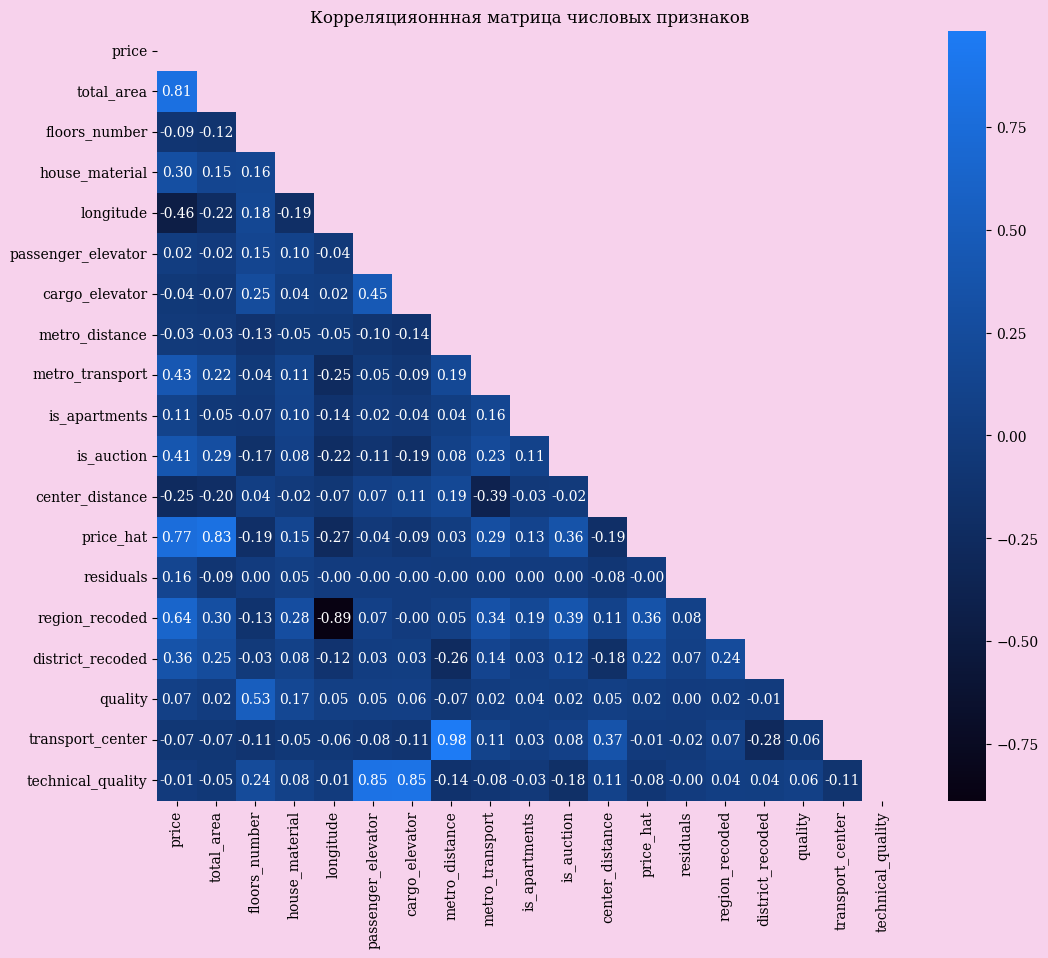

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_features = df.select_dtypes(include=np.number)

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(numeric_features.corr(), dtype=bool))
sns.heatmap(numeric_features.corr(), annot=True, cmap=cmap,
            fmt=".2f", mask = mask)
plt.title('Корреляцияоннная матрица числовых признаков')
plt.show()


Взглянем на эту вкусную матричку корреляций и увидим, что тут достаточно много признаков, которые коррелируют между собой, причем достаточно сильно

In [ ]:
from utils import *

### Промежуточная модель

 - total_area - самая большая корреляция на price, ну грех не взять
 - longitude - тоже неплохая корреляция
 - metro_transport - аналогично
 - is_auction - неполхая корреляция, но есть и между признаками
 - district_recoded - аналогично


 - region_recoded - не взяла, тк у него большая корреляция с другими признаками

In [ ]:
features = ['total_area', 'longitude', 'metro_transport', 'is_auction', 'district_recoded']

In [ ]:
numeric_features = df[features]

X_vif = sm.add_constant(numeric_features)
vif_data = pd.DataFrame()
vif_data["variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data_sorted = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data_sorted)

           variable        VIF
0             const  78.487574
1        total_area   1.192007
4        is_auction   1.147620
3   metro_transport   1.130371
2         longitude   1.122163
5  district_recoded   1.078507


В целом VIF не сильно далеко от 1, это неплохо.

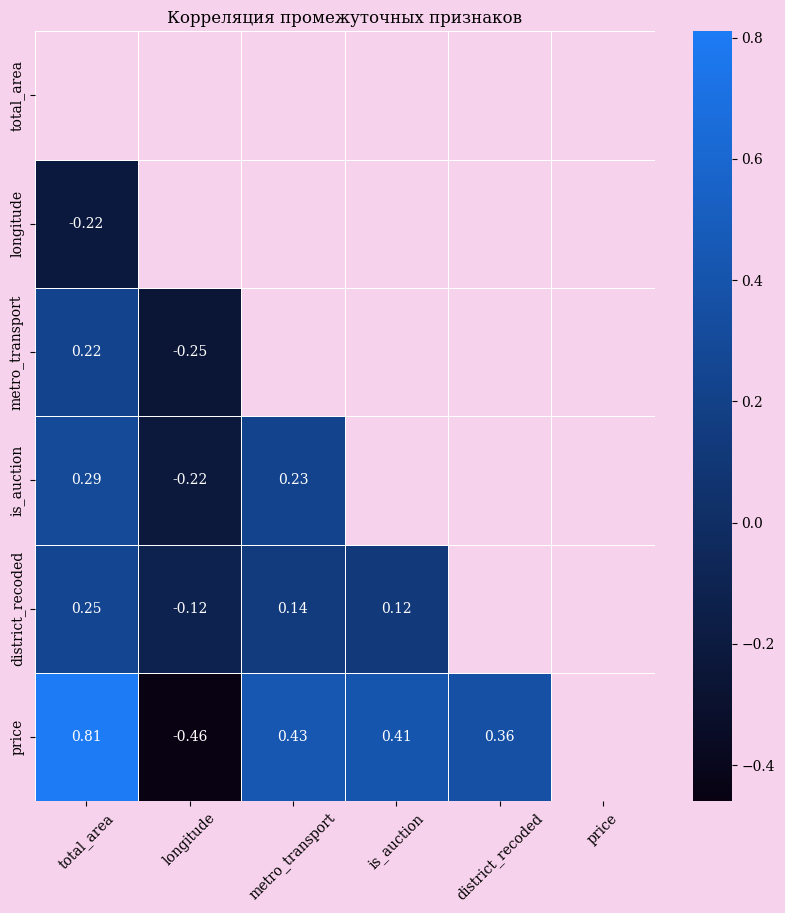

In [ ]:
features_viz = features.copy()
features_viz.append('price')
df_selected = df[features_viz]
corr_matrix = df_selected.corr()
plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt=".2f",
            mask = mask,
            linewidths=0.5)

plt.title('Корреляция промежуточных признаков')
plt.xticks(rotation=45)
plt.show()

да, коррреляция между признаками не супер большая, терпимо, теперь обучим модель

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     5090.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:30:37   Log-Likelihood:                 78957.
No. Observations:                5977   AIC:                        -1.579e+05
Df Residuals:                    5971   BIC:                        -1.579e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.161e-05   5.08e-08  

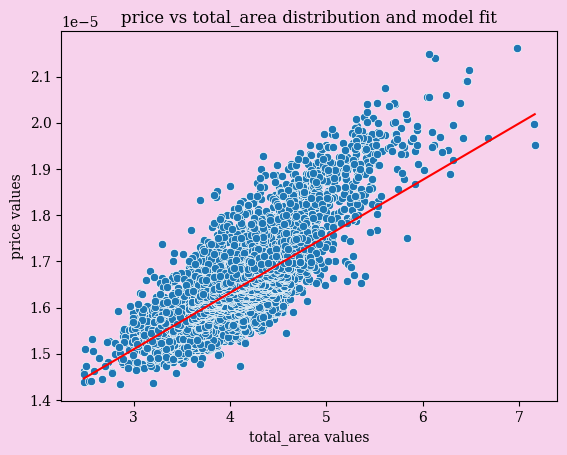

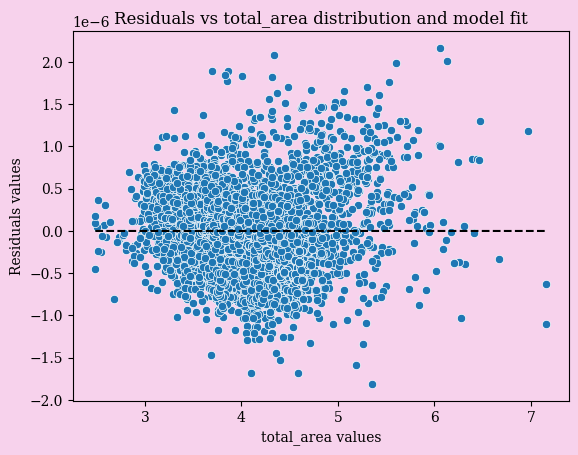

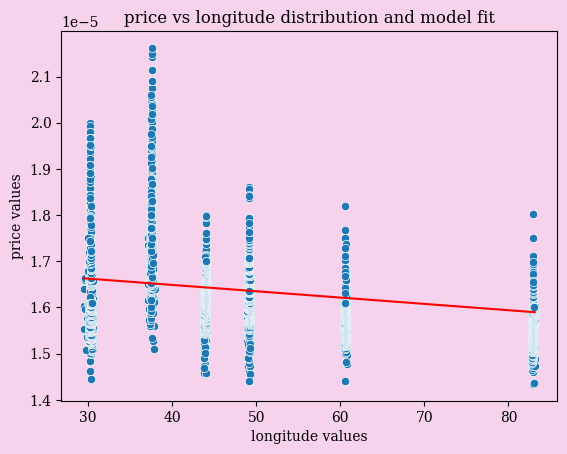

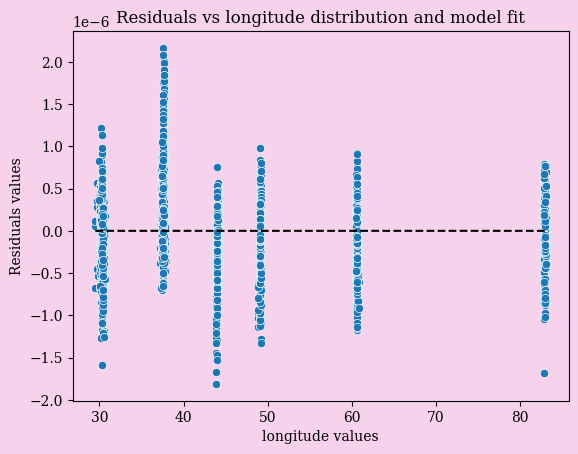

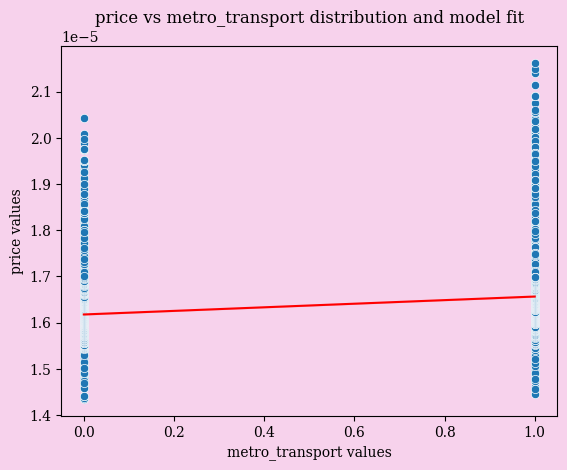

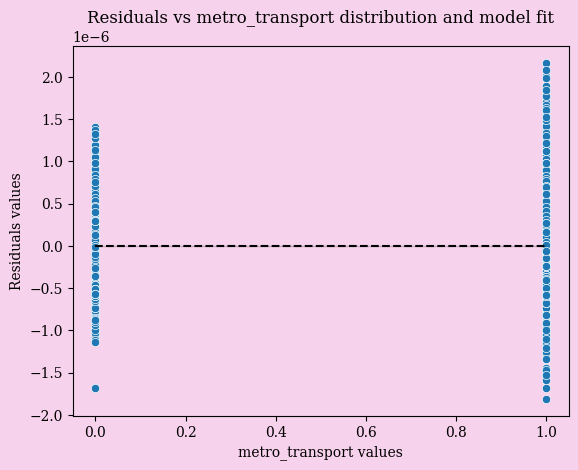

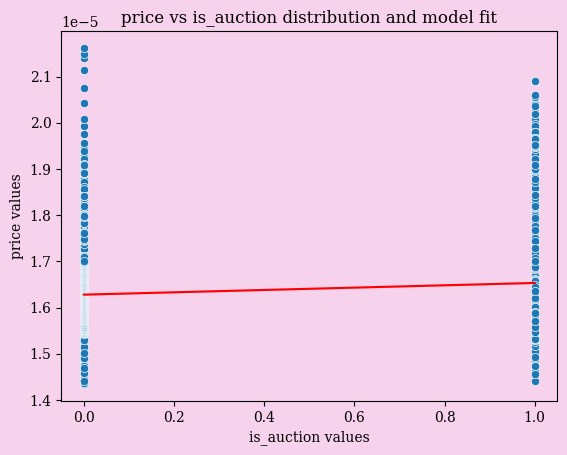

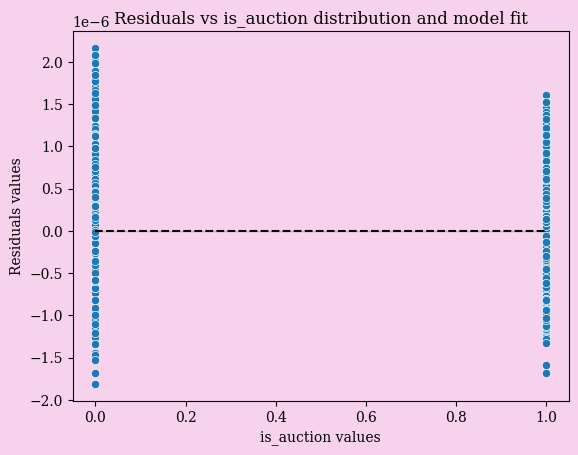

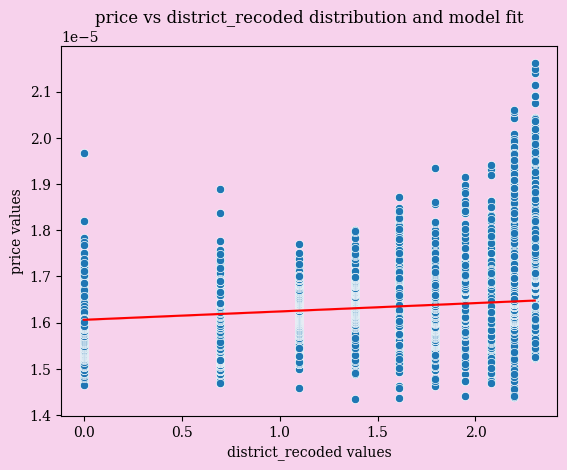

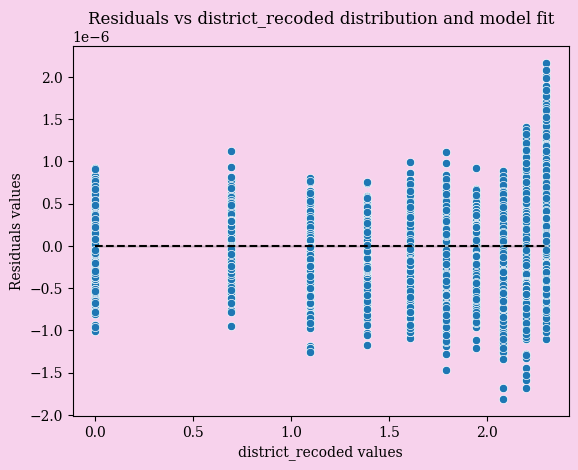

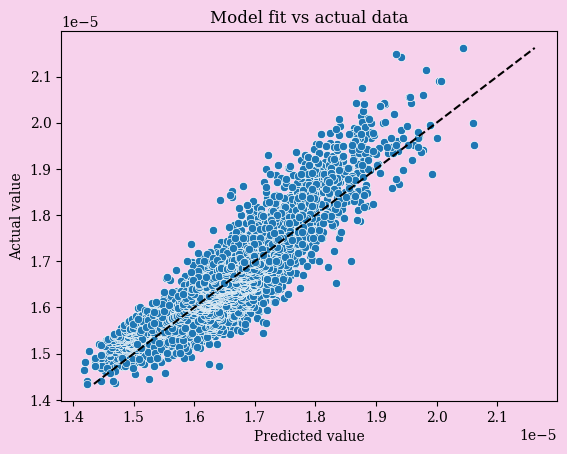

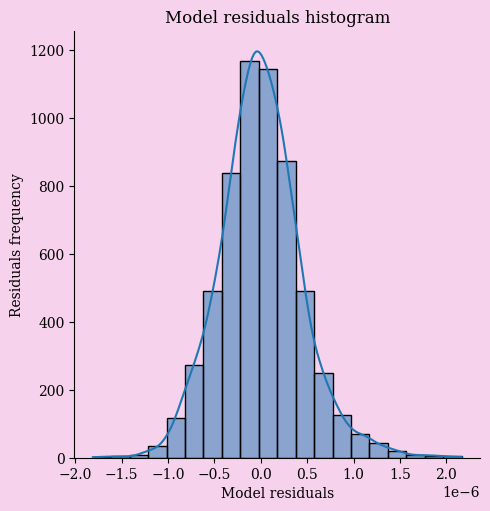

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5977.



test  p_level  a_level    a_calc a_calc >= a_level  \
0             Shapiro-Wilk test     0.95     0.05       0.0             False   
1              Epps-Pulley test     0.95     0.05         -                 -   
2   D'Agostino's K-squared test     0.95     0.05       0.0             False   
3         Anderson-Darling test     0.95     0.05                               
4       Kolmogorov–Smirnov test     0.95     0.05  0.000001             False   
5               Lilliefors test     0.95     0.05     0.001             False   
6         Cramér–von Mises test     0.95     0.05  0.000011             False   
7              Chi-squared test     0.95     0.05       1.0              True   
8              Jarque–Bera test     0.95     0.05       0.0             False   
9                      skewtest     0.95     0.05       0.0             False   
10                 kurtosistest     0.95     0.05       0.0             False   

                  statistic critical_value statistic < critical_value  \
0                  0.987585                                             
1                         -              -                      False   
2                266.907174                                             
3                 13.294885          0.786                      False   
4                   0.03452                                             
5                  0.034538                                             
6                  2.024224                                             
7  -314236280258567929856.0                                             
8                466.913501                                             
9                 11.102613                                             
10                11.984956                                             

                   conclusion  
0   not gaussian distribution  
1        count more than 1000  
2   not gaussian distribution  
3   not gaussian distribution  
4   not gaussian distribution  
5   not gaussian distribution  
6   not gaussian distribution  
7       gaussian distribution  
8   not gaussian distribution  
9   not gaussian distribution  
10  not gaussian distribution

In [ ]:
df, model_heteroskedasticity = train_model(
df, target='price', feature_names=features, show_results=True, return_norm_tests=True)

Отлично, наш R-square увеличился до 0.81, уже достаточно неплохо, посмотрим можно ли сделать еще лучше. Распределение остатков уже сильно улучшилось, оно не является нормальным, но хотя бы не выглядит печально.

VIF тоже в пределах 1, не превышает 1,2. Мультиколлинеарность есть, но не очень большая => такая модель в целом имеет право на жизнь

Займемся интересной работой подбора лучших признаков 😀

### Финальные регрессоры

In [ ]:
features = ['total_area', 'house_material', 'longitude', 'district_recoded',
            'metro_transport', 'is_apartments', 'quality', 'floors_number',
            'transport_center','is_auction', 'technical_quality', ]

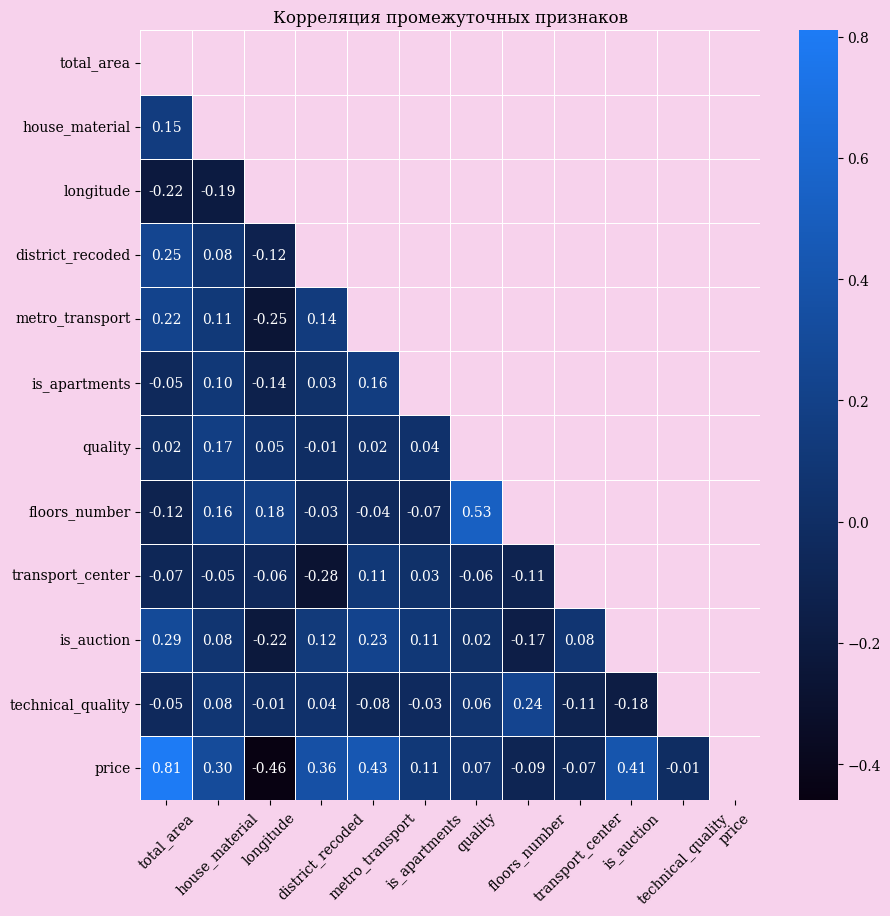

In [ ]:
features_viz = features.copy()
features_viz.append('price')
df_selected = df[features_viz]
corr_matrix = df_selected.corr()
plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt=".2f",
            mask = mask,
            linewidths=0.5)

plt.title('Корреляция промежуточных признаков')
plt.xticks(rotation=45)
plt.show()

In [ ]:
numeric_features = df[features]

X_vif = sm.add_constant(numeric_features)
vif_data = pd.DataFrame()
vif_data["variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data_sorted = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data_sorted)

             variable         VIF
0               const  256.117515
8       floors_number    1.605259
7             quality    1.435241
1          total_area    1.243751
10         is_auction    1.213289
3           longitude    1.202407
4    district_recoded    1.181866
5     metro_transport    1.177357
9    transport_center    1.143097
2      house_material    1.129624
11  technical_quality    1.108826
6       is_apartments    1.073255


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     2670.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:32:25   Log-Likelihood:                 79310.
No. Observations:                5977   AIC:                        -1.586e+05
Df Residuals:                    5965   BIC:                        -1.585e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.136e-05   8.66e-0

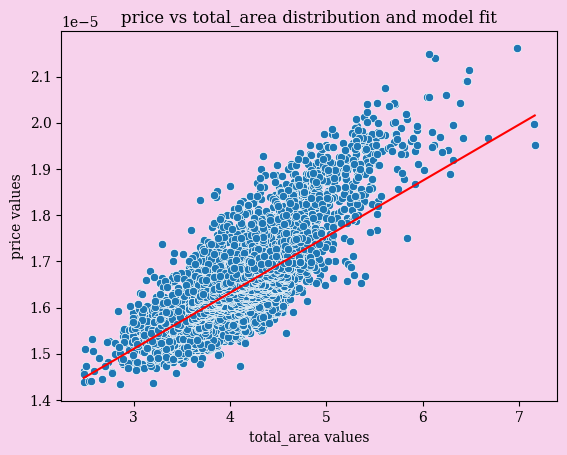

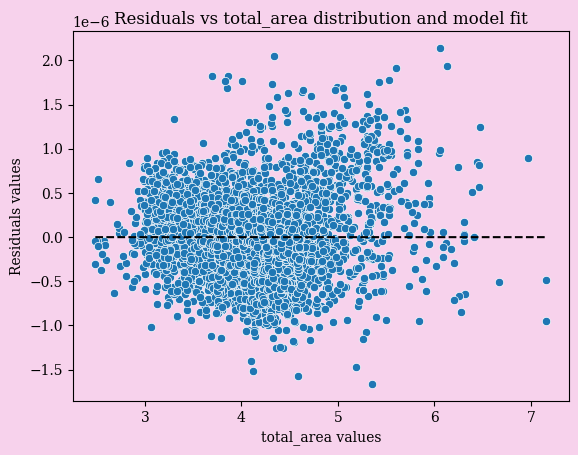

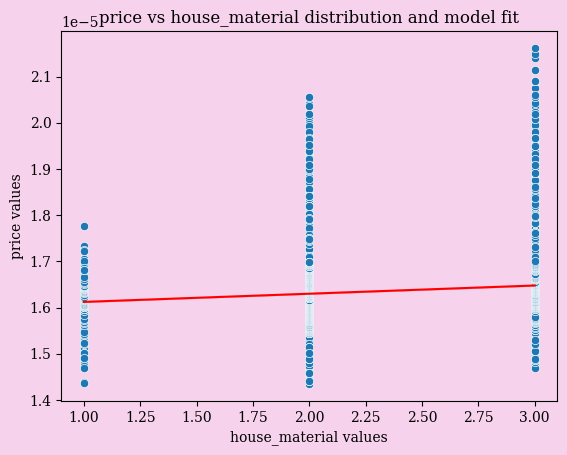

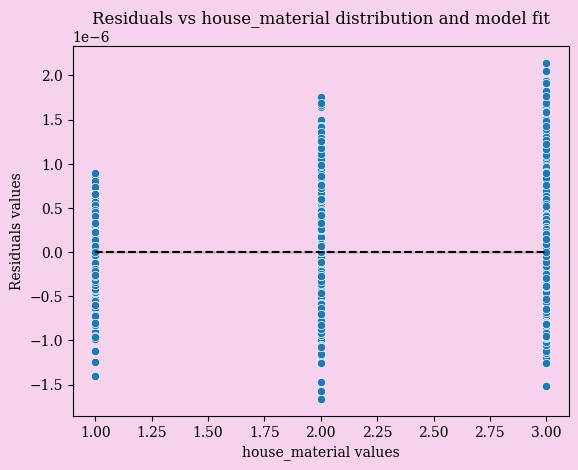

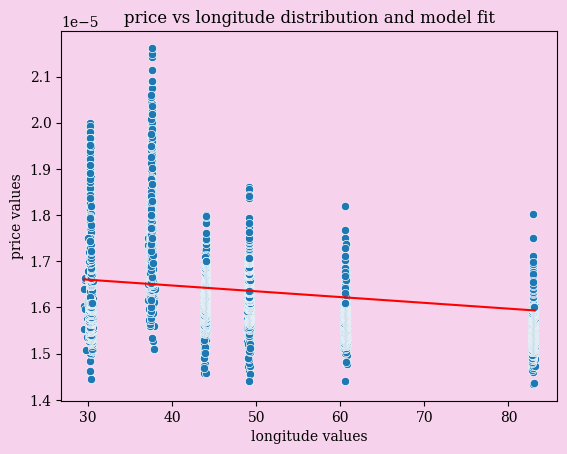

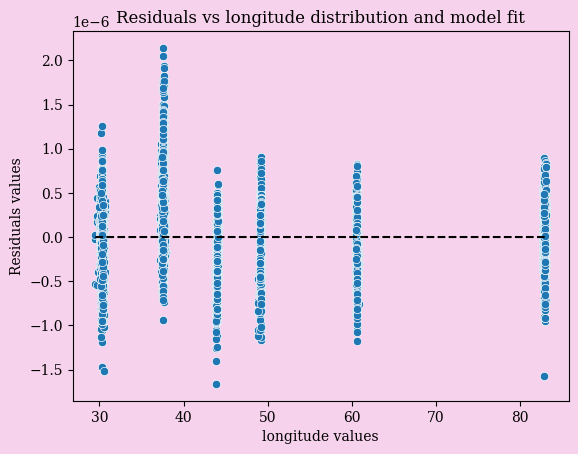

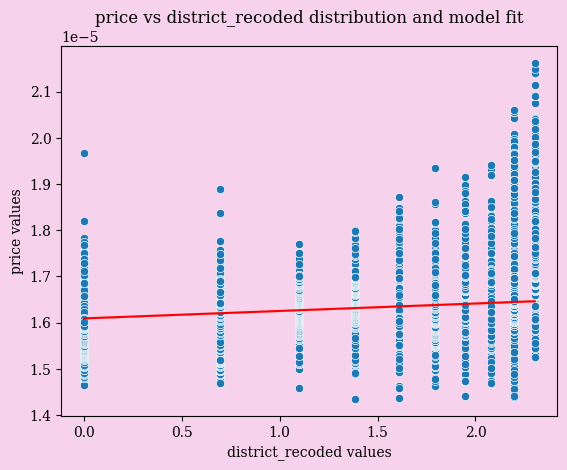

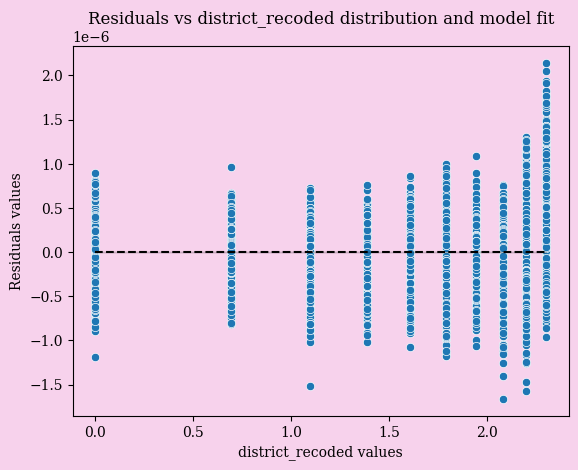

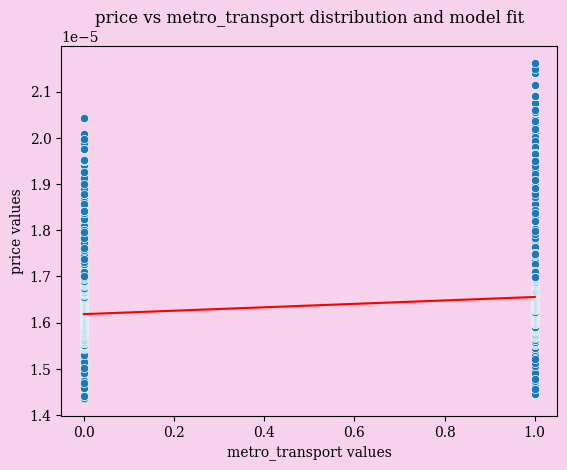

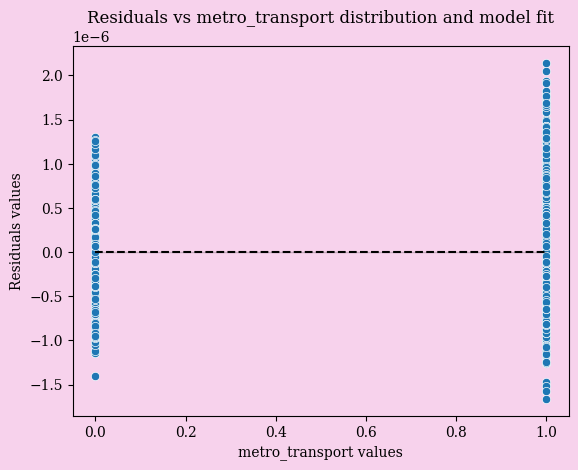

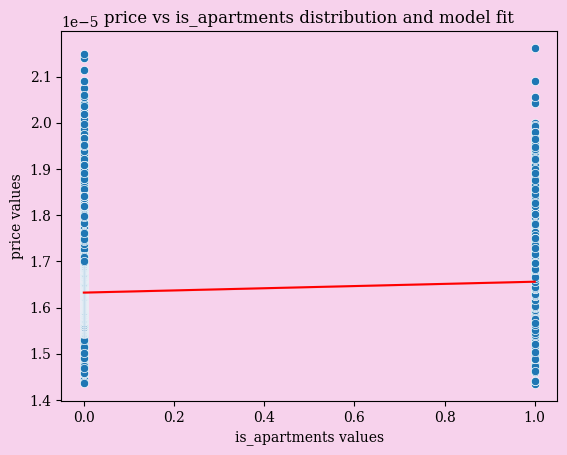

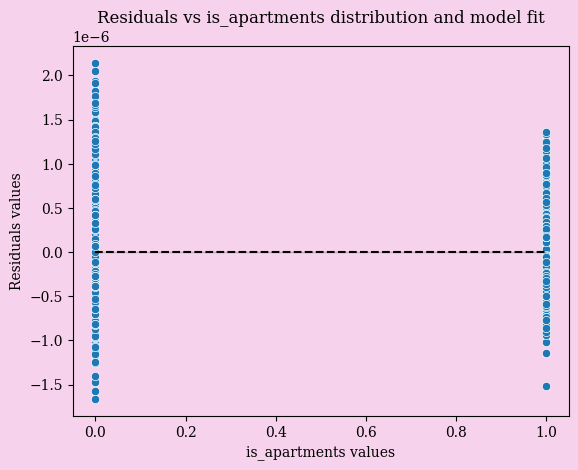

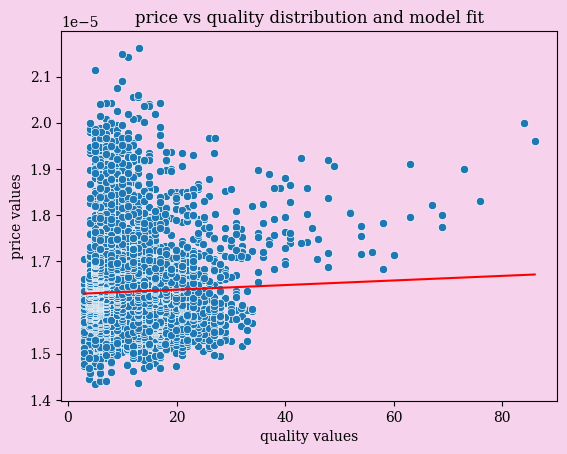

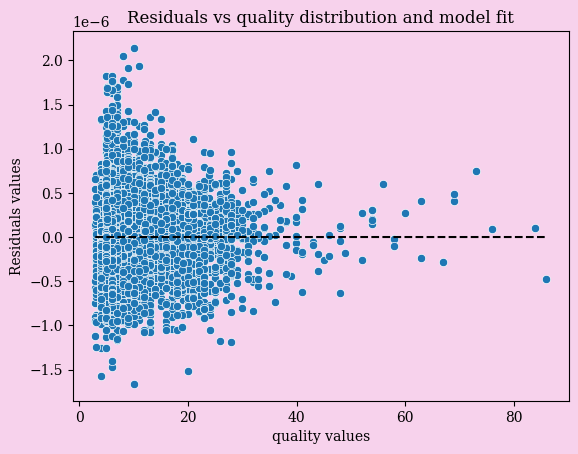

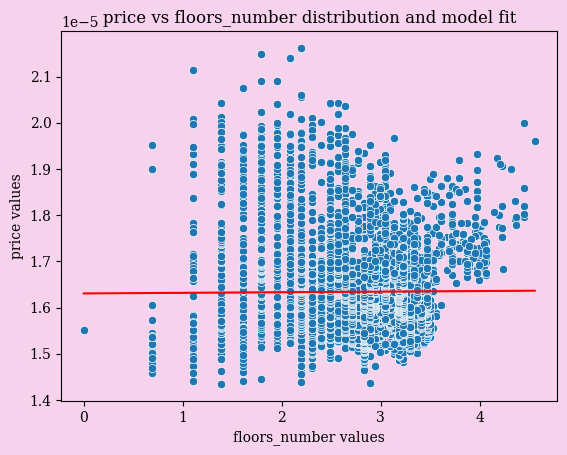

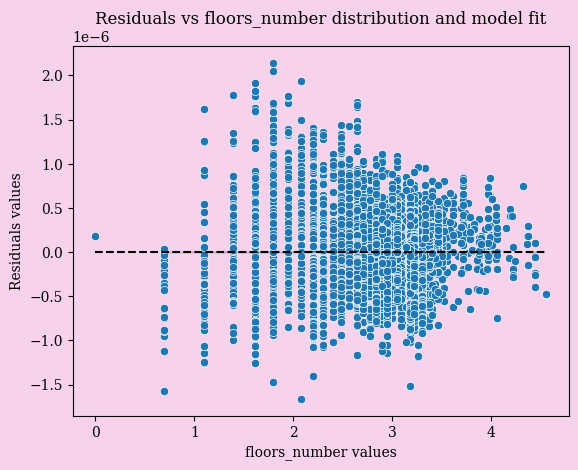

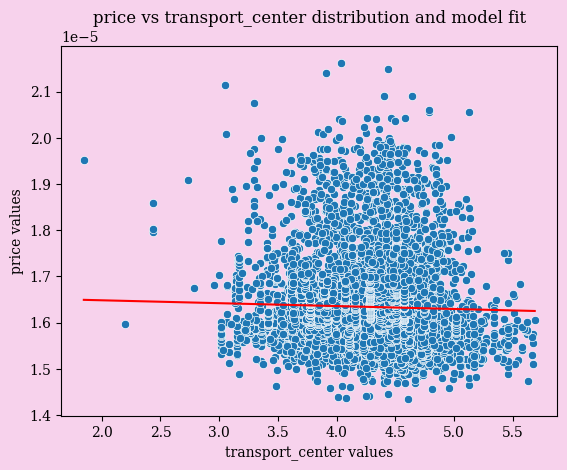

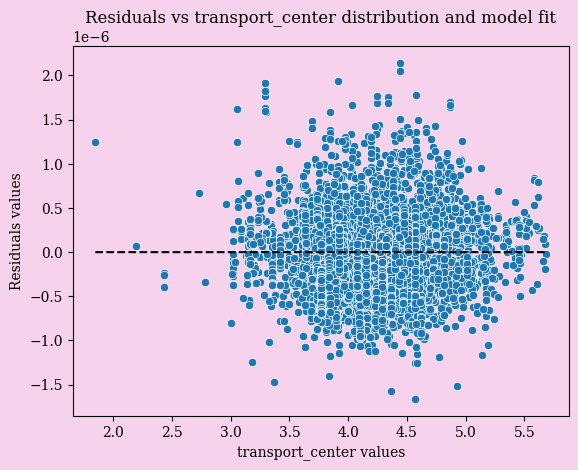

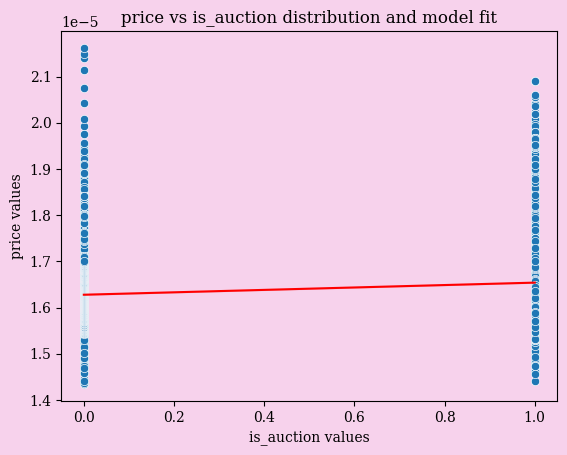

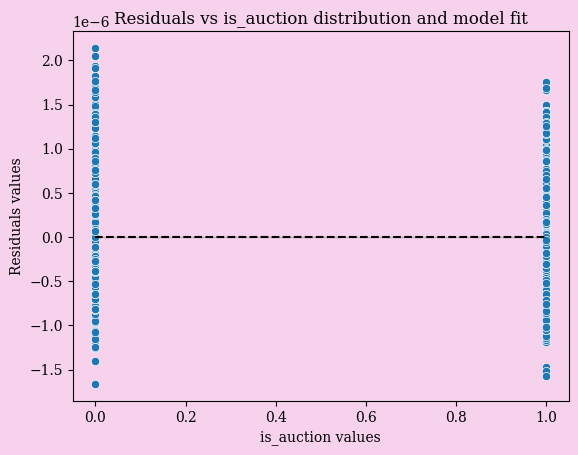

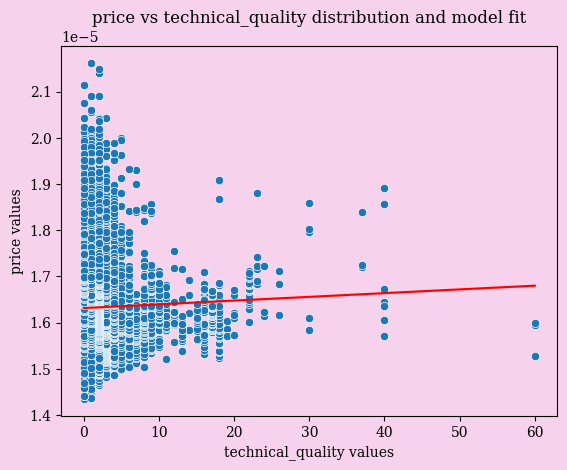

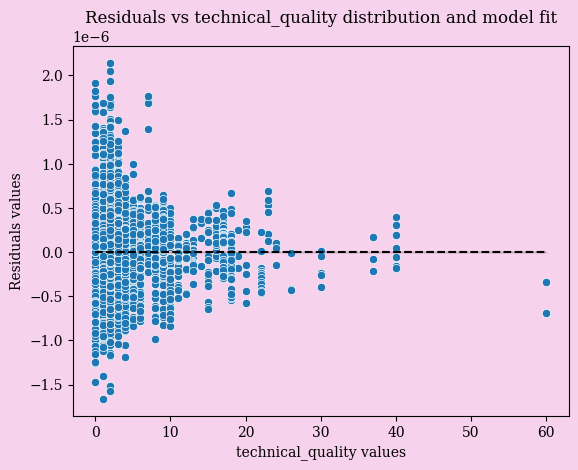

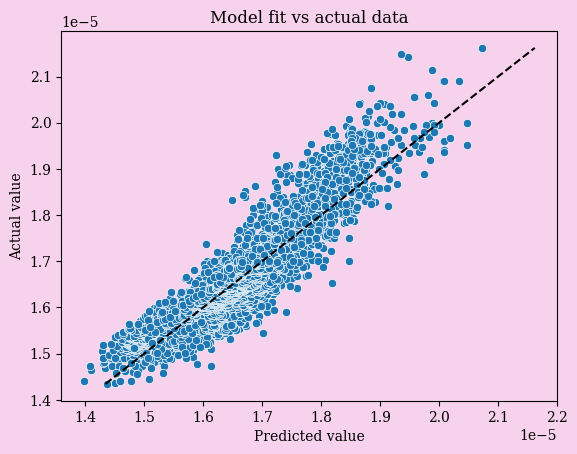

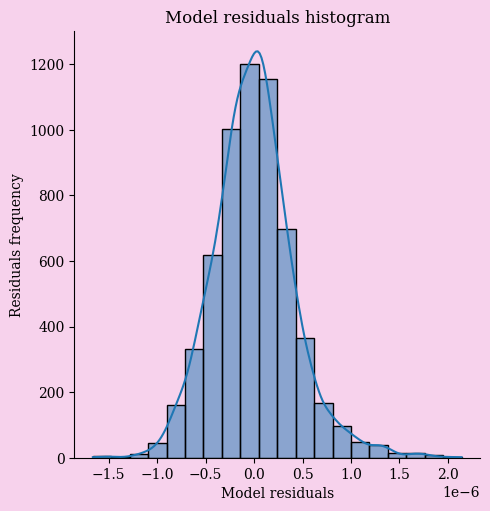

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5977.

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide



test  p_level  a_level a_calc a_calc >= a_level  \
0             Shapiro-Wilk test     0.95     0.05    0.0             False   
1              Epps-Pulley test     0.95     0.05      -                 -   
2   D'Agostino's K-squared test     0.95     0.05    0.0             False   
3         Anderson-Darling test     0.95     0.05                            
4       Kolmogorov–Smirnov test     0.95     0.05    0.0             False   
5               Lilliefors test     0.95     0.05  0.001             False   
6         Cramér–von Mises test     0.95     0.05    0.0             False   
7              Chi-squared test     0.95     0.05    0.0             False   
8              Jarque–Bera test     0.95     0.05    0.0             False   
9                      skewtest     0.95     0.05    0.0             False   
10                 kurtosistest     0.95     0.05    0.0             False   

     statistic critical_value statistic < critical_value  \
0     0.980804                                             
1            -              -                      False   
2   427.827102                                             
3    19.336793          0.786                      False   
4     0.042044                                             
5      0.04206                                             
6     2.875508                                             
7          inf                                             
8   813.694633                                             
9    15.133036                                             
10   14.100295                                             

                   conclusion  
0   not gaussian distribution  
1        count more than 1000  
2   not gaussian distribution  
3   not gaussian distribution  
4   not gaussian distribution  
5   not gaussian distribution  
6   not gaussian distribution  
7   not gaussian distribution  
8   not gaussian distribution  
9   not gaussian distribution  
10  not gaussian distribution

In [ ]:
df, model_heteroskedasticity = train_model(
df, target='price', feature_names=features, show_results=True, return_norm_tests=True)

Пока что получили 0.83, в целом, уже по сравнению с 0.56 уже хорошо, но от 0.81 мы далеко не ушли

К сожалению тесты на нормальное распределение остатков не прошли, но вид распределения уже сильно улучшился по сравнению с первой моделью. Видим по графикам из репорта что полностью с выбросами нам справиться не удалось и полностью убрать гетероскедастичность тоже, но мы получили в целом неплохой результат

# Общий вывод по работе

Это было достаточно тяжко. Обработка признаков и создание новых признаков заняли очень большое количество времени. Сам датасет очень интересный, было интересно с ним работать, но данные, на мой взгляд, немного грязноваты. Тем не менее считаю, что датасет хороший, тк встретилась с некоторыми прроблемами и попыталась их решить



---


По гипотезам: <пока ничего>



---

По регрессии: опять же, было интересно изучать признаки. В данных обнаружились проблемы с дисперсией (большой разброс цен, например, тк в Москве наблюдались просто невероятные цены).
Помогло для начала отмасштабировать данные из рублей  в миллионы рублей и прологарифмировать их. Также помогло введение новых признаков: очень хорошо помогла перекодировка района (добавило около 0.1 к R-square)


Я еще пыталась парсить OpenStreetMaps, чтобы ввести признак качества инфраструктуры по району, но в итоге вышло так, что у него была почти нулевая корреляция с price и от этой идеи пришлось отказаться.

P.S Тут изменения поздно внесены, тк я недавно увидела, что у меня оказывается криво дата фреймы печатаются, пришлось пересохранять 😞